In [1]:
import math
import torch
import gpytorch

import pyro
pyro.enable_validation(True)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

In [2]:
%pdb

Automatic pdb calling has been turned ON


## Introduction

In this notebook, we how to train a functional kernel learning model, training on a simple function. We'll be modeling the function

\begin{align*}
  y &= \sin(2\pi x) + \epsilon \\
  \epsilon &\sim \mathcal{N}(0, 0.2)
\end{align*}

with 11 training examples, and testing on 51 test examples.

For more mathematical detail, please see the paper Functional Distributions over Kernels (NeurIPS 2019).

**Note:** this notebook is not necessarily intended to teach the mathematical background of Gaussian processes, but rather how to train a simple one and make predictions in GPyTorch. For a mathematical treatment, Chapter 2 of Gaussian Processes for Machine Learning provides a very thorough introduction to GP regression (this entire text is highly recommended): http://www.gaussianprocess.org/gpml/chapters/RW2.pdf


#### Set up the GPyTorch Model with Spectral GP kernel
Using the same framework as standard GPyTorch models, we merely drop-in the spectral GP kernel as the covar module

The `initialize_from_data` method does some pre-training on the latent model using the log-periodogram of data as training targets.

For specifics on the components of GPyTorch models we refer to the [GPyTorch Documentation](https://gpytorch.readthedocs.io/en/latest/index.html)

In [3]:
class SpectralModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, **kwargs):
        super(SpectralModel, self).__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.SpectralGPKernel(**kwargs)
        #self.covar_module.initialize_from_data(train_x, train_y, **kwargs)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


#### Generate training data and Build GP Model
Generate points in [0, 5] and a sine wave to serve as the response, then split into training and test data.

Pass this data into the GP model from above along with a likelihood

In [4]:
nx = 200
split = 150
full_x = torch.linspace(0, 5, nx)
full_y = torch.sin(2 * full_x)

train_x = full_x[:split]
train_y = full_y[:split]

test_x = full_x[(split - nx):]
test_y = full_y[(split - nx):]

### Define latent model

In [5]:
class PVGPRegressionModel(gpytorch.models.PyroVariationalGP):
    def __init__(self, train_x, train_y, likelihood, name_prefix="mixture_gp"):
        # Define all the variational stuff
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=train_x.numel()
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, train_x, variational_distribution
        )
        
        # Standard initializtation
        super(PVGPRegressionModel, self).__init__(variational_strategy, likelihood, num_data=train_x.numel())
        self.likelihood = likelihood
        
        # Mean, covar
        self.mean_module = gpytorch.means.LogRBFMean()
        
        #we specify prior here
        prior_rbf_length = 0.3 
        lengthscale_prior = gpytorch.priors.NormalPrior(prior_rbf_length, 1.0) #variance does not matter much
        
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior),
        )
        
        # Initialize lengthscale and outputscale to mean of priors
        self.covar_module.base_kernel.lengthscale = lengthscale_prior.mean
        #self.covar_module.outputscale = outputscale_prior.mean

    def forward(self, x):
        #print('shape of input is: ', x.shape)
        mean = self.mean_module(x)  # Returns an n_data vec
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [6]:
class FKL_GPModel(gpytorch.likelihoods.GaussianLikelihood):
    def __init__(self, train_x, train_y, data_likelihood, **kwargs):
        super(FKL_GPModel, self).__init__()
        
        self._max_plate_nesting = 1
        self.data_likelihood = data_likelihood
        self.data_model = SpectralModel(train_x, train_y, self.data_likelihood, 
                                        register_latent_params = False, **kwargs)
        self.train_x = train_x
        self.train_y = train_y
        
    def expected_log_prob(self, target, input_dist):
        latent_gp = self.gplink_function(input_dist.mean)
        self.data_model.covar_module.latent_params = latent_gp
        self.data_model.prediction_strategy = None
        
        if not self.training:
            dist = self.data_model(*params, **kwargs)
        else:
            dist = self.data_lh(self.data_model(self.train_x))
        
        elp = dist.log_prob(target)
        return elp
    
    @staticmethod
    def gplink_function(f):
        ### gp link function is inside the kernel
        return f.view(-1)
    
    def forward(self, function_samples, *params, **kwargs):
        omega = self.data_model.covar_module.omega.data.numpy()
        print(function_samples.shape, omega.shape)
#         plt.plot(omega, function_samples.data.numpy())
#         plt.show()
        
        latent_gp = self.gplink_function(function_samples)
        self.data_model.covar_module.latent_params = latent_gp
        self.data_model.prediction_strategy = None
        
        if not self.training:
            return self.data_model(*params, **kwargs)
        else:
            return self.data_likelihood(self.data_model(self.train_x))

In [7]:
omega = torch.arange(1e-4, 1., 0.01)

data_lh = gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.SmoothedBoxPrior(1e-8, 1e-4))
data_gp = FKL_GPModel(train_x, train_y, data_lh, omega = omega)

model = PVGPRegressionModel(omega, train_y, data_gp)

In [8]:
data_gp.train();

In [24]:
# train the model
from pyro import optim

base_lr = 1e-3
iter_print = 1

print('Basic lr for most of parameters: {}'.format(base_lr))

# set learning rates for different hyperparameters
def per_param_callable(module_name, param_name):
    if param_name == 'covar_module.base_kernel.raw_lengthscale':
        return {"lr": 0.1}
    elif param_name == 'variational_strategy.variational_distribution.variational_mean':
        return {"lr": base_lr}
    else:
        return {"lr": base_lr}

# Use the adam optimizer
optimizer = optim.Adam(per_param_callable)

pyro.clear_param_store() # clean run

losses, rbf, means = [], [], []

means.append(model.variational_strategy.variational_distribution.\
             variational_mean.detach().cpu().numpy()) #save initial mean

def train(num_iter=2000):
    elbo = pyro.infer.Trace_ELBO(num_particles=1, vectorize_particles=True)
    svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)
    model.train()

    for i in range(num_iter):
        model.zero_grad()
        loss = svi.step(omega, train_y)
        losses.append(loss)
        rbf.append(model.covar_module.base_kernel.lengthscale.item())
        if not (i + 1) % iter_print:
            print('Iter {}/{} - Loss: {:.3}   lengthscale: {:.3}'.format(
                i + 1, num_iter, loss,
                model.covar_module.base_kernel.lengthscale.item(),
            ))
            means.append(model.variational_strategy.variational_distribution.\
                         variational_mean.detach().cpu().numpy())
        
%time train()

Basic lr for most of parameters: 0.001
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")
/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


torch.Size([100]) (100,)
Iter 1/2000 - Loss: -2.9e+02   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 2/2000 - Loss: -1.78e+02   lengthscale: 0.156
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 3/2000 - Loss: -2.38e+02   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 4/2000 - Loss: -3.23e+02   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 5/2000 - Loss: -2.54e+02   lengthscale: 0.158
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 6/2000 - Loss: -2.59e+02   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 7/2000 - Loss: -1.51e+02   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 8/2000 - Loss: -2.83e+02   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 9/2000 - Loss: -2.75e+02   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 10/2000 - Loss: -3.61e+02   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 11/2000 - Loss: -3.51e+02   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 12/2000 - Loss: -3.17e+02   lengthscale: 0.157
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 13/2000 - Loss: -2.86e+02   lengthscale: 0.159
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 14/2000 - Loss: -3.47e+02   lengthscale: 0.163
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 15/2000 - Loss: -4.66e+02   lengthscale: 0.168
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 16/2000 - Loss: -3.01e+02   lengthscale: 0.173
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 17/2000 - Loss: -2.42e+02   lengthscale: 0.179
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 18/2000 - Loss: -3.88e+02   lengthscale: 0.176
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 19/2000 - Loss: -4.07e+02   lengthscale: 0.172
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 20/2000 - Loss: -3.3e+02   lengthscale: 0.169
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 21/2000 - Loss: -3.76e+02   lengthscale: 0.166
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 22/2000 - Loss: -3.36e+02   lengthscale: 0.164
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 23/2000 - Loss: -3.77e+02   lengthscale: 0.162
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 24/2000 - Loss: -3.75e+02   lengthscale: 0.16
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 25/2000 - Loss: -3.98e+02   lengthscale: 0.159
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 26/2000 - Loss: -4.09e+02   lengthscale: 0.158
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 27/2000 - Loss: -4.77e+02   lengthscale: 0.157
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 28/2000 - Loss: -4.86e+02   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 29/2000 - Loss: -4.08e+02   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 30/2000 - Loss: -4.08e+02   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 31/2000 - Loss: -4.92e+02   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 32/2000 - Loss: -4.73e+02   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 33/2000 - Loss: -4.37e+02   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 34/2000 - Loss: -4.31e+02   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 35/2000 - Loss: -4.95e+02   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 36/2000 - Loss: -5.13e+02   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 37/2000 - Loss: -5.08e+02   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 38/2000 - Loss: -5.43e+02   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 39/2000 - Loss: -4.82e+02   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 40/2000 - Loss: -4.7e+02   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 41/2000 - Loss: -4.75e+02   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 42/2000 - Loss: -4.88e+02   lengthscale: 0.155
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 43/2000 - Loss: -4.95e+02   lengthscale: 0.155
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 44/2000 - Loss: -6.06e+02   lengthscale: 0.156
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 45/2000 - Loss: -4.97e+02   lengthscale: 0.156
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 46/2000 - Loss: -6.15e+02   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 47/2000 - Loss: -5.83e+02   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 48/2000 - Loss: -5.79e+02   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 49/2000 - Loss: -3.89e+02   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 50/2000 - Loss: -5.26e+02   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 51/2000 - Loss: -6.2e+02   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 52/2000 - Loss: -6.29e+02   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 53/2000 - Loss: -6.72e+02   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 54/2000 - Loss: -6.82e+02   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 55/2000 - Loss: -5.85e+02   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 56/2000 - Loss: -5.86e+02   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 57/2000 - Loss: -6.7e+02   lengthscale: 0.155
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 58/2000 - Loss: -6.08e+02   lengthscale: 0.157
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 59/2000 - Loss: -5.54e+02   lengthscale: 0.158
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 60/2000 - Loss: -7.48e+02   lengthscale: 0.16
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 61/2000 - Loss: -7.11e+02   lengthscale: 0.162
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 62/2000 - Loss: -5.75e+02   lengthscale: 0.164
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 63/2000 - Loss: -6.81e+02   lengthscale: 0.166
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 64/2000 - Loss: -6.62e+02   lengthscale: 0.167
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 65/2000 - Loss: -7.15e+02   lengthscale: 0.167
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 66/2000 - Loss: -6.1e+02   lengthscale: 0.164
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 67/2000 - Loss: -6.98e+02   lengthscale: 0.158
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 68/2000 - Loss: -7.21e+02   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 69/2000 - Loss: -7e+02   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 70/2000 - Loss: -7.5e+02   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 71/2000 - Loss: -7.95e+02   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 72/2000 - Loss: -7.51e+02   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 73/2000 - Loss: -7.95e+02   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 74/2000 - Loss: -7.63e+02   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 75/2000 - Loss: -6.91e+02   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 76/2000 - Loss: -8.3e+02   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 77/2000 - Loss: -8.31e+02   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 78/2000 - Loss: -7.07e+02   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 79/2000 - Loss: -8.18e+02   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 80/2000 - Loss: -7.64e+02   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 81/2000 - Loss: -8.19e+02   lengthscale: 0.155
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 82/2000 - Loss: -8.63e+02   lengthscale: 0.158
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 83/2000 - Loss: -7.67e+02   lengthscale: 0.16
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 84/2000 - Loss: -8.15e+02   lengthscale: 0.159
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 85/2000 - Loss: -8e+02   lengthscale: 0.158
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 86/2000 - Loss: -7.92e+02   lengthscale: 0.158
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 87/2000 - Loss: -8.35e+02   lengthscale: 0.158
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 88/2000 - Loss: -8.52e+02   lengthscale: 0.159
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 89/2000 - Loss: -8.17e+02   lengthscale: 0.157
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 90/2000 - Loss: -9.49e+02   lengthscale: 0.156
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 91/2000 - Loss: -9.1e+02   lengthscale: 0.156
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 92/2000 - Loss: -8.9e+02   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 93/2000 - Loss: -8.98e+02   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 94/2000 - Loss: -9.22e+02   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 95/2000 - Loss: -8.45e+02   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 96/2000 - Loss: -9.56e+02   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 97/2000 - Loss: -9.12e+02   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 98/2000 - Loss: -7.59e+02   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 99/2000 - Loss: -7.89e+02   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 100/2000 - Loss: -9.05e+02   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 101/2000 - Loss: -9.82e+02   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 102/2000 - Loss: -8.46e+02   lengthscale: 0.156
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 103/2000 - Loss: -9.75e+02   lengthscale: 0.158
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 104/2000 - Loss: -9.72e+02   lengthscale: 0.162
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 105/2000 - Loss: -8.43e+02   lengthscale: 0.165
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 106/2000 - Loss: -8.65e+02   lengthscale: 0.168
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 107/2000 - Loss: -1.03e+03   lengthscale: 0.166
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 108/2000 - Loss: -1.02e+03   lengthscale: 0.163
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 109/2000 - Loss: -8.93e+02   lengthscale: 0.156
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 110/2000 - Loss: -9.16e+02   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 111/2000 - Loss: -1.05e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 112/2000 - Loss: -1.08e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 113/2000 - Loss: -1.09e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 114/2000 - Loss: -1.09e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 115/2000 - Loss: -1.11e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 116/2000 - Loss: -1.06e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 117/2000 - Loss: -1.04e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 118/2000 - Loss: -1.14e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 119/2000 - Loss: -1.03e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 120/2000 - Loss: -9.76e+02   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 121/2000 - Loss: -1.1e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 122/2000 - Loss: -1.07e+03   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 123/2000 - Loss: -1.13e+03   lengthscale: 0.155
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 124/2000 - Loss: -1.09e+03   lengthscale: 0.157
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 125/2000 - Loss: -1.08e+03   lengthscale: 0.16
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 126/2000 - Loss: -1.12e+03   lengthscale: 0.163
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 127/2000 - Loss: -1.13e+03   lengthscale: 0.166
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 128/2000 - Loss: -1.2e+03   lengthscale: 0.169
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 129/2000 - Loss: -1.12e+03   lengthscale: 0.173
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 130/2000 - Loss: -1.15e+03   lengthscale: 0.176
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 131/2000 - Loss: -1.14e+03   lengthscale: 0.169
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 132/2000 - Loss: -1.22e+03   lengthscale: 0.162
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 133/2000 - Loss: -1.16e+03   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 134/2000 - Loss: -1.17e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 135/2000 - Loss: -1.13e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 136/2000 - Loss: -1.22e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 137/2000 - Loss: -1.23e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 138/2000 - Loss: -1.25e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 139/2000 - Loss: -1.19e+03   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 140/2000 - Loss: -1.27e+03   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 141/2000 - Loss: -1.16e+03   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 142/2000 - Loss: -1.08e+03   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 143/2000 - Loss: -1.25e+03   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 144/2000 - Loss: -1.3e+03   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 145/2000 - Loss: -1.26e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 146/2000 - Loss: -1.33e+03   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 147/2000 - Loss: -1.19e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 148/2000 - Loss: -1.28e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 149/2000 - Loss: -1.29e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 150/2000 - Loss: -1.33e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 151/2000 - Loss: -1.31e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 152/2000 - Loss: -1.3e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 153/2000 - Loss: -1.33e+03   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 154/2000 - Loss: -1.27e+03   lengthscale: 0.156
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 155/2000 - Loss: -1.28e+03   lengthscale: 0.158
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 156/2000 - Loss: -1.32e+03   lengthscale: 0.156
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 157/2000 - Loss: -1.33e+03   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 158/2000 - Loss: -1.3e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 159/2000 - Loss: -1.27e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 160/2000 - Loss: -1.36e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 161/2000 - Loss: -1.35e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 162/2000 - Loss: -1.38e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 163/2000 - Loss: -1.4e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 164/2000 - Loss: -1.42e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 165/2000 - Loss: -1.39e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 166/2000 - Loss: -1.37e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 167/2000 - Loss: -1.42e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 168/2000 - Loss: -1.38e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 169/2000 - Loss: -1.43e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 170/2000 - Loss: -1.39e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 171/2000 - Loss: -1.34e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 172/2000 - Loss: -1.34e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 173/2000 - Loss: -1.43e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 174/2000 - Loss: -1.41e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 175/2000 - Loss: -1.48e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 176/2000 - Loss: -1.49e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 177/2000 - Loss: -1.48e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 178/2000 - Loss: -1.44e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 179/2000 - Loss: -1.45e+03   lengthscale: 0.156
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 180/2000 - Loss: -1.52e+03   lengthscale: 0.161
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 181/2000 - Loss: -1.55e+03   lengthscale: 0.165
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 182/2000 - Loss: -1.36e+03   lengthscale: 0.168
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 183/2000 - Loss: -1.53e+03   lengthscale: 0.172
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 184/2000 - Loss: -1.49e+03   lengthscale: 0.174
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 185/2000 - Loss: -1.49e+03   lengthscale: 0.177
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 186/2000 - Loss: -1.47e+03   lengthscale: 0.17
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 187/2000 - Loss: -1.47e+03   lengthscale: 0.155
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 188/2000 - Loss: -1.51e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 189/2000 - Loss: -1.56e+03   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 190/2000 - Loss: -1.53e+03   lengthscale: 0.123
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 191/2000 - Loss: -1.62e+03   lengthscale: 0.116
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 192/2000 - Loss: -1.57e+03   lengthscale: 0.111
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 193/2000 - Loss: -1.54e+03   lengthscale: 0.108
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 194/2000 - Loss: -1.59e+03   lengthscale: 0.106
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 195/2000 - Loss: -1.63e+03   lengthscale: 0.105
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 196/2000 - Loss: -1.56e+03   lengthscale: 0.105
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 197/2000 - Loss: -1.61e+03   lengthscale: 0.105
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 198/2000 - Loss: -1.65e+03   lengthscale: 0.106
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 199/2000 - Loss: -1.71e+03   lengthscale: 0.108
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 200/2000 - Loss: -1.61e+03   lengthscale: 0.11
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 201/2000 - Loss: -1.62e+03   lengthscale: 0.113
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 202/2000 - Loss: -1.53e+03   lengthscale: 0.116
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 203/2000 - Loss: -1.62e+03   lengthscale: 0.12
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 204/2000 - Loss: -1.52e+03   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 205/2000 - Loss: -1.63e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 206/2000 - Loss: -1.72e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 207/2000 - Loss: -1.7e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 208/2000 - Loss: -1.65e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 209/2000 - Loss: -1.77e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 210/2000 - Loss: -1.67e+03   lengthscale: 0.156
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 211/2000 - Loss: -1.73e+03   lengthscale: 0.163
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 212/2000 - Loss: -1.65e+03   lengthscale: 0.168
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 213/2000 - Loss: -1.71e+03   lengthscale: 0.173
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 214/2000 - Loss: -1.71e+03   lengthscale: 0.176
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 215/2000 - Loss: -1.75e+03   lengthscale: 0.179
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 216/2000 - Loss: -1.69e+03   lengthscale: 0.181
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 217/2000 - Loss: -1.7e+03   lengthscale: 0.18
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 218/2000 - Loss: -1.68e+03   lengthscale: 0.165
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 219/2000 - Loss: -1.77e+03   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 220/2000 - Loss: -1.78e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 221/2000 - Loss: -1.79e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 222/2000 - Loss: -1.76e+03   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 223/2000 - Loss: -1.6e+03   lengthscale: 0.123
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 224/2000 - Loss: -1.83e+03   lengthscale: 0.119
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 225/2000 - Loss: -1.81e+03   lengthscale: 0.117
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 226/2000 - Loss: -1.81e+03   lengthscale: 0.114
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 227/2000 - Loss: -1.76e+03   lengthscale: 0.113
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 228/2000 - Loss: -1.81e+03   lengthscale: 0.112
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 229/2000 - Loss: -1.78e+03   lengthscale: 0.112
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 230/2000 - Loss: -1.8e+03   lengthscale: 0.113
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 231/2000 - Loss: -1.85e+03   lengthscale: 0.114
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 232/2000 - Loss: -1.78e+03   lengthscale: 0.116
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 233/2000 - Loss: -1.89e+03   lengthscale: 0.118
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 234/2000 - Loss: -1.8e+03   lengthscale: 0.121
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 235/2000 - Loss: -1.91e+03   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 236/2000 - Loss: -1.92e+03   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 237/2000 - Loss: -1.81e+03   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 238/2000 - Loss: -1.93e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 239/2000 - Loss: -1.96e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 240/2000 - Loss: -1.87e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 241/2000 - Loss: -1.89e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 242/2000 - Loss: -1.98e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 243/2000 - Loss: -1.85e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 244/2000 - Loss: -1.86e+03   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 245/2000 - Loss: -1.92e+03   lengthscale: 0.158
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 246/2000 - Loss: -1.89e+03   lengthscale: 0.16
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 247/2000 - Loss: -1.93e+03   lengthscale: 0.162
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 248/2000 - Loss: -1.95e+03   lengthscale: 0.164
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 249/2000 - Loss: -1.95e+03   lengthscale: 0.16
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 250/2000 - Loss: -1.96e+03   lengthscale: 0.157
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 251/2000 - Loss: -2e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 252/2000 - Loss: -1.97e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 253/2000 - Loss: -1.93e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 254/2000 - Loss: -2.01e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 255/2000 - Loss: -2e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 256/2000 - Loss: -1.94e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 257/2000 - Loss: -1.99e+03   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 258/2000 - Loss: -2.03e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 259/2000 - Loss: -2.02e+03   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 260/2000 - Loss: -2.09e+03   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 261/2000 - Loss: -2.08e+03   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 262/2000 - Loss: -2.04e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 263/2000 - Loss: -2.16e+03   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 264/2000 - Loss: -2.07e+03   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 265/2000 - Loss: -2.06e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 266/2000 - Loss: -2.06e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 267/2000 - Loss: -2.09e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 268/2000 - Loss: -1.99e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 269/2000 - Loss: -2.03e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 270/2000 - Loss: -2.1e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 271/2000 - Loss: -2.12e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 272/2000 - Loss: -2.04e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 273/2000 - Loss: -2.14e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 274/2000 - Loss: -2.16e+03   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 275/2000 - Loss: -2.12e+03   lengthscale: 0.157
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 276/2000 - Loss: -2.13e+03   lengthscale: 0.157
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 277/2000 - Loss: -2.08e+03   lengthscale: 0.157
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 278/2000 - Loss: -2.1e+03   lengthscale: 0.157
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 279/2000 - Loss: -2.18e+03   lengthscale: 0.157
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 280/2000 - Loss: -2.18e+03   lengthscale: 0.157
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 281/2000 - Loss: -2.11e+03   lengthscale: 0.157
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 282/2000 - Loss: -2.19e+03   lengthscale: 0.158
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 283/2000 - Loss: -2.22e+03   lengthscale: 0.159
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 284/2000 - Loss: -2.21e+03   lengthscale: 0.161
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 285/2000 - Loss: -2.18e+03   lengthscale: 0.162
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 286/2000 - Loss: -2.17e+03   lengthscale: 0.164
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 287/2000 - Loss: -2.04e+03   lengthscale: 0.162
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 288/2000 - Loss: -2.15e+03   lengthscale: 0.16
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 289/2000 - Loss: -2.11e+03   lengthscale: 0.157
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 290/2000 - Loss: -2.3e+03   lengthscale: 0.155
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 291/2000 - Loss: -2.26e+03   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 292/2000 - Loss: -2.18e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 293/2000 - Loss: -2.21e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 294/2000 - Loss: -2.24e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 295/2000 - Loss: -2.26e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 296/2000 - Loss: -2.24e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 297/2000 - Loss: -2.27e+03   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 298/2000 - Loss: -2.3e+03   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 299/2000 - Loss: -2.18e+03   lengthscale: 0.155
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 300/2000 - Loss: -2.3e+03   lengthscale: 0.155
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 301/2000 - Loss: -2.37e+03   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 302/2000 - Loss: -2.36e+03   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 303/2000 - Loss: -2.35e+03   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 304/2000 - Loss: -2.37e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 305/2000 - Loss: -2.41e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 306/2000 - Loss: -2.37e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 307/2000 - Loss: -2.33e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 308/2000 - Loss: -2.36e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 309/2000 - Loss: -2.4e+03   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 310/2000 - Loss: -2.37e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 311/2000 - Loss: -2.38e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 312/2000 - Loss: -2.29e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 313/2000 - Loss: -2.4e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 314/2000 - Loss: -2.38e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 315/2000 - Loss: -2.4e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 316/2000 - Loss: -2.47e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 317/2000 - Loss: -2.44e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 318/2000 - Loss: -2.44e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 319/2000 - Loss: -2.3e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 320/2000 - Loss: -2.43e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 321/2000 - Loss: -2.36e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 322/2000 - Loss: -2.48e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 323/2000 - Loss: -2.48e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 324/2000 - Loss: -2.43e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 325/2000 - Loss: -2.45e+03   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 326/2000 - Loss: -2.47e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 327/2000 - Loss: -2.47e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 328/2000 - Loss: -2.53e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 329/2000 - Loss: -2.45e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 330/2000 - Loss: -2.58e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 331/2000 - Loss: -2.54e+03   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 332/2000 - Loss: -2.5e+03   lengthscale: 0.156
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 333/2000 - Loss: -2.55e+03   lengthscale: 0.158
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 334/2000 - Loss: -2.54e+03   lengthscale: 0.159
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 335/2000 - Loss: -2.52e+03   lengthscale: 0.161
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 336/2000 - Loss: -2.56e+03   lengthscale: 0.16
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 337/2000 - Loss: -2.57e+03   lengthscale: 0.159
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 338/2000 - Loss: -2.51e+03   lengthscale: 0.158
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 339/2000 - Loss: -2.57e+03   lengthscale: 0.158
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 340/2000 - Loss: -2.59e+03   lengthscale: 0.158
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 341/2000 - Loss: -2.6e+03   lengthscale: 0.158
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 342/2000 - Loss: -2.56e+03   lengthscale: 0.157
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 343/2000 - Loss: -2.52e+03   lengthscale: 0.155
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 344/2000 - Loss: -2.62e+03   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 345/2000 - Loss: -2.61e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 346/2000 - Loss: -2.66e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 347/2000 - Loss: -2.6e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 348/2000 - Loss: -2.66e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 349/2000 - Loss: -2.56e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 350/2000 - Loss: -2.66e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 351/2000 - Loss: -2.67e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 352/2000 - Loss: -2.65e+03   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 353/2000 - Loss: -2.65e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 354/2000 - Loss: -2.7e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 355/2000 - Loss: -2.62e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 356/2000 - Loss: -2.7e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 357/2000 - Loss: -2.7e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 358/2000 - Loss: -2.67e+03   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 359/2000 - Loss: -2.75e+03   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 360/2000 - Loss: -2.74e+03   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 361/2000 - Loss: -2.79e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 362/2000 - Loss: -2.78e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 363/2000 - Loss: -2.73e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 364/2000 - Loss: -2.71e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 365/2000 - Loss: -2.73e+03   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 366/2000 - Loss: -2.71e+03   lengthscale: 0.157
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 367/2000 - Loss: -2.83e+03   lengthscale: 0.159
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 368/2000 - Loss: -2.78e+03   lengthscale: 0.162
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 369/2000 - Loss: -2.77e+03   lengthscale: 0.164
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 370/2000 - Loss: -2.77e+03   lengthscale: 0.165
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 371/2000 - Loss: -2.8e+03   lengthscale: 0.16
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 372/2000 - Loss: -2.79e+03   lengthscale: 0.155
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 373/2000 - Loss: -2.84e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 374/2000 - Loss: -2.86e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 375/2000 - Loss: -2.75e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 376/2000 - Loss: -2.83e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 377/2000 - Loss: -2.83e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 378/2000 - Loss: -2.8e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 379/2000 - Loss: -2.76e+03   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 380/2000 - Loss: -2.87e+03   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 381/2000 - Loss: -2.88e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 382/2000 - Loss: -2.92e+03   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 383/2000 - Loss: -2.87e+03   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 384/2000 - Loss: -2.74e+03   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 385/2000 - Loss: -2.94e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 386/2000 - Loss: -2.94e+03   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 387/2000 - Loss: -2.85e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 388/2000 - Loss: -2.79e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 389/2000 - Loss: -2.93e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 390/2000 - Loss: -2.94e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 391/2000 - Loss: -2.86e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 392/2000 - Loss: -2.9e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 393/2000 - Loss: -2.86e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 394/2000 - Loss: -2.94e+03   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 395/2000 - Loss: -2.99e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 396/2000 - Loss: -2.98e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 397/2000 - Loss: -2.93e+03   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 398/2000 - Loss: -2.94e+03   lengthscale: 0.156
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 399/2000 - Loss: -3.02e+03   lengthscale: 0.158
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 400/2000 - Loss: -2.94e+03   lengthscale: 0.155
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 401/2000 - Loss: -2.91e+03   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 402/2000 - Loss: -3.02e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 403/2000 - Loss: -2.93e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 404/2000 - Loss: -3.01e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 405/2000 - Loss: -2.99e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 406/2000 - Loss: -2.99e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 407/2000 - Loss: -3e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 408/2000 - Loss: -3.07e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 409/2000 - Loss: -3.05e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 410/2000 - Loss: -3.06e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 411/2000 - Loss: -3.02e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 412/2000 - Loss: -3.1e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 413/2000 - Loss: -3e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 414/2000 - Loss: -2.86e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 415/2000 - Loss: -3e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 416/2000 - Loss: -3.08e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 417/2000 - Loss: -3.09e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 418/2000 - Loss: -3.13e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 419/2000 - Loss: -3.12e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 420/2000 - Loss: -3.11e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 421/2000 - Loss: -3.14e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 422/2000 - Loss: -3.1e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 423/2000 - Loss: -3.22e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 424/2000 - Loss: -3.12e+03   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 425/2000 - Loss: -3.18e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 426/2000 - Loss: -3.17e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 427/2000 - Loss: -3.21e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 428/2000 - Loss: -3.16e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 429/2000 - Loss: -3.05e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 430/2000 - Loss: -3.17e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 431/2000 - Loss: -3.18e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 432/2000 - Loss: -3.19e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 433/2000 - Loss: -3.12e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 434/2000 - Loss: -3.23e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 435/2000 - Loss: -3.25e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 436/2000 - Loss: -3.22e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 437/2000 - Loss: -3.33e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 438/2000 - Loss: -3.22e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 439/2000 - Loss: -3.04e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 440/2000 - Loss: -3.34e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 441/2000 - Loss: -3.29e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 442/2000 - Loss: -3.32e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 443/2000 - Loss: -3.33e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 444/2000 - Loss: -3.23e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 445/2000 - Loss: -3.33e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 446/2000 - Loss: -3.3e+03   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 447/2000 - Loss: -3.24e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 448/2000 - Loss: -3.32e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 449/2000 - Loss: -3.38e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 450/2000 - Loss: -3.33e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 451/2000 - Loss: -3.32e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 452/2000 - Loss: -3.35e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 453/2000 - Loss: -3.37e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 454/2000 - Loss: -3.41e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 455/2000 - Loss: -3.34e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 456/2000 - Loss: -3.36e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 457/2000 - Loss: -3.31e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 458/2000 - Loss: -3.39e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 459/2000 - Loss: -3.38e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 460/2000 - Loss: -3.41e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 461/2000 - Loss: -3.4e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 462/2000 - Loss: -3.46e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 463/2000 - Loss: -3.44e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 464/2000 - Loss: -3.39e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 465/2000 - Loss: -3.25e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 466/2000 - Loss: -3.36e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 467/2000 - Loss: -3.48e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 468/2000 - Loss: -3.45e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 469/2000 - Loss: -3.5e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 470/2000 - Loss: -3.46e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 471/2000 - Loss: -3.45e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 472/2000 - Loss: -3.5e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 473/2000 - Loss: -3.42e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 474/2000 - Loss: -3.52e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 475/2000 - Loss: -3.43e+03   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 476/2000 - Loss: -3.53e+03   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 477/2000 - Loss: -3.49e+03   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 478/2000 - Loss: -3.52e+03   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 479/2000 - Loss: -3.55e+03   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 480/2000 - Loss: -3.52e+03   lengthscale: 0.155
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 481/2000 - Loss: -3.56e+03   lengthscale: 0.156
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 482/2000 - Loss: -3.48e+03   lengthscale: 0.156
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 483/2000 - Loss: -3.44e+03   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 484/2000 - Loss: -3.56e+03   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 485/2000 - Loss: -3.43e+03   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 486/2000 - Loss: -3.54e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 487/2000 - Loss: -3.55e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 488/2000 - Loss: -3.64e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 489/2000 - Loss: -3.57e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 490/2000 - Loss: -3.51e+03   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 491/2000 - Loss: -3.59e+03   lengthscale: 0.121
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 492/2000 - Loss: -3.58e+03   lengthscale: 0.116
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 493/2000 - Loss: -3.57e+03   lengthscale: 0.112
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 494/2000 - Loss: -3.63e+03   lengthscale: 0.109
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 495/2000 - Loss: -3.57e+03   lengthscale: 0.107
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 496/2000 - Loss: -3.63e+03   lengthscale: 0.106
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 497/2000 - Loss: -3.72e+03   lengthscale: 0.106
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 498/2000 - Loss: -3.59e+03   lengthscale: 0.107
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 499/2000 - Loss: -3.61e+03   lengthscale: 0.108
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 500/2000 - Loss: -3.63e+03   lengthscale: 0.11
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 501/2000 - Loss: -3.71e+03   lengthscale: 0.112
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 502/2000 - Loss: -3.75e+03   lengthscale: 0.115
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 503/2000 - Loss: -3.69e+03   lengthscale: 0.118
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 504/2000 - Loss: -3.75e+03   lengthscale: 0.121
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 505/2000 - Loss: -3.75e+03   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 506/2000 - Loss: -3.77e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 507/2000 - Loss: -3.78e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 508/2000 - Loss: -3.48e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 509/2000 - Loss: -3.74e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 510/2000 - Loss: -3.71e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 511/2000 - Loss: -3.68e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 512/2000 - Loss: -3.74e+03   lengthscale: 0.155
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 513/2000 - Loss: -3.69e+03   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 514/2000 - Loss: -3.83e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 515/2000 - Loss: -3.73e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 516/2000 - Loss: -3.8e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 517/2000 - Loss: -3.78e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 518/2000 - Loss: -3.77e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 519/2000 - Loss: -3.73e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 520/2000 - Loss: -3.7e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 521/2000 - Loss: -3.81e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 522/2000 - Loss: -3.84e+03   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 523/2000 - Loss: -3.64e+03   lengthscale: 0.123
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 524/2000 - Loss: -3.86e+03   lengthscale: 0.122
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 525/2000 - Loss: -3.88e+03   lengthscale: 0.12
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 526/2000 - Loss: -3.82e+03   lengthscale: 0.12
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 527/2000 - Loss: -3.84e+03   lengthscale: 0.12
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 528/2000 - Loss: -3.85e+03   lengthscale: 0.121
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 529/2000 - Loss: -3.83e+03   lengthscale: 0.122
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 530/2000 - Loss: -3.88e+03   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 531/2000 - Loss: -3.89e+03   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 532/2000 - Loss: -3.9e+03   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 533/2000 - Loss: -3.83e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 534/2000 - Loss: -3.95e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 535/2000 - Loss: -3.83e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 536/2000 - Loss: -3.83e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 537/2000 - Loss: -3.92e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 538/2000 - Loss: -3.92e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 539/2000 - Loss: -3.96e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 540/2000 - Loss: -3.93e+03   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 541/2000 - Loss: -3.92e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 542/2000 - Loss: -3.96e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 543/2000 - Loss: -3.84e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 544/2000 - Loss: -3.98e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 545/2000 - Loss: -3.89e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 546/2000 - Loss: -4.02e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 547/2000 - Loss: -4.07e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 548/2000 - Loss: -3.99e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 549/2000 - Loss: -4.01e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 550/2000 - Loss: -4.01e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 551/2000 - Loss: -3.98e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 552/2000 - Loss: -4.01e+03   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 553/2000 - Loss: -3.9e+03   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 554/2000 - Loss: -4.02e+03   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 555/2000 - Loss: -3.86e+03   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 556/2000 - Loss: -3.99e+03   lengthscale: 0.155
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 557/2000 - Loss: -4e+03   lengthscale: 0.156
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 558/2000 - Loss: -4.02e+03   lengthscale: 0.156
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 559/2000 - Loss: -4.07e+03   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 560/2000 - Loss: -4.08e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 561/2000 - Loss: -4.11e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 562/2000 - Loss: -4.08e+03   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 563/2000 - Loss: -4.11e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 564/2000 - Loss: -3.97e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 565/2000 - Loss: -4.12e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 566/2000 - Loss: -4.19e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 567/2000 - Loss: -4.1e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 568/2000 - Loss: -4.12e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 569/2000 - Loss: -4.15e+03   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 570/2000 - Loss: -4.12e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 571/2000 - Loss: -4.09e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 572/2000 - Loss: -4.2e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 573/2000 - Loss: -4.16e+03   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 574/2000 - Loss: -4.08e+03   lengthscale: 0.155
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 575/2000 - Loss: -4.26e+03   lengthscale: 0.155
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 576/2000 - Loss: -4.15e+03   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 577/2000 - Loss: -4.21e+03   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 578/2000 - Loss: -4.24e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 579/2000 - Loss: -4.17e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 580/2000 - Loss: -4.22e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 581/2000 - Loss: -4.07e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 582/2000 - Loss: -4.21e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 583/2000 - Loss: -4.22e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 584/2000 - Loss: -4.23e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 585/2000 - Loss: -4.24e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 586/2000 - Loss: -4.28e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 587/2000 - Loss: -4.25e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 588/2000 - Loss: -4.27e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 589/2000 - Loss: -4.33e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 590/2000 - Loss: -4.25e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 591/2000 - Loss: -4.31e+03   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 592/2000 - Loss: -4.31e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 593/2000 - Loss: -4.34e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 594/2000 - Loss: -4.28e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 595/2000 - Loss: -4.33e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 596/2000 - Loss: -4.21e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 597/2000 - Loss: -4.38e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 598/2000 - Loss: -4.34e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 599/2000 - Loss: -4.33e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 600/2000 - Loss: -4.36e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 601/2000 - Loss: -4.34e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 602/2000 - Loss: -4.31e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 603/2000 - Loss: -4.42e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 604/2000 - Loss: -4.38e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 605/2000 - Loss: -4.34e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 606/2000 - Loss: -4.3e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 607/2000 - Loss: -4.44e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 608/2000 - Loss: -4.42e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 609/2000 - Loss: -4.42e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 610/2000 - Loss: -4.36e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 611/2000 - Loss: -4.48e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 612/2000 - Loss: -4.51e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 613/2000 - Loss: -4.34e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 614/2000 - Loss: -4.47e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 615/2000 - Loss: -4.5e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 616/2000 - Loss: -4.44e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 617/2000 - Loss: -4.5e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 618/2000 - Loss: -4.55e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 619/2000 - Loss: -4.51e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 620/2000 - Loss: -4.42e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 621/2000 - Loss: -4.31e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 622/2000 - Loss: -4.44e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 623/2000 - Loss: -4.5e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 624/2000 - Loss: -4.57e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 625/2000 - Loss: -4.52e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 626/2000 - Loss: -4.55e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 627/2000 - Loss: -4.52e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 628/2000 - Loss: -4.53e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 629/2000 - Loss: -4.56e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 630/2000 - Loss: -4.54e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 631/2000 - Loss: -4.61e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 632/2000 - Loss: -4.47e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 633/2000 - Loss: -4.55e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 634/2000 - Loss: -4.54e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 635/2000 - Loss: -4.51e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 636/2000 - Loss: -4.65e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 637/2000 - Loss: -4.64e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 638/2000 - Loss: -4.38e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 639/2000 - Loss: -4.64e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 640/2000 - Loss: -4.68e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 641/2000 - Loss: -4.61e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 642/2000 - Loss: -4.62e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 643/2000 - Loss: -4.57e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 644/2000 - Loss: -4.68e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 645/2000 - Loss: -4.69e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 646/2000 - Loss: -4.64e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 647/2000 - Loss: -4.68e+03   lengthscale: 0.155
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 648/2000 - Loss: -4.62e+03   lengthscale: 0.159
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 649/2000 - Loss: -4.6e+03   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 650/2000 - Loss: -4.74e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 651/2000 - Loss: -4.69e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 652/2000 - Loss: -4.71e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 653/2000 - Loss: -4.7e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 654/2000 - Loss: -4.65e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 655/2000 - Loss: -4.72e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 656/2000 - Loss: -4.76e+03   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 657/2000 - Loss: -4.76e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 658/2000 - Loss: -4.74e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 659/2000 - Loss: -4.71e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 660/2000 - Loss: -4.78e+03   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 661/2000 - Loss: -4.78e+03   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 662/2000 - Loss: -4.78e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 663/2000 - Loss: -4.8e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 664/2000 - Loss: -4.73e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 665/2000 - Loss: -4.85e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 666/2000 - Loss: -4.81e+03   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 667/2000 - Loss: -4.63e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 668/2000 - Loss: -4.76e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 669/2000 - Loss: -4.83e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 670/2000 - Loss: -4.8e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 671/2000 - Loss: -4.86e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 672/2000 - Loss: -4.9e+03   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 673/2000 - Loss: -4.85e+03   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 674/2000 - Loss: -4.83e+03   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 675/2000 - Loss: -4.8e+03   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 676/2000 - Loss: -4.89e+03   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 677/2000 - Loss: -4.74e+03   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 678/2000 - Loss: -4.84e+03   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 679/2000 - Loss: -4.85e+03   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 680/2000 - Loss: -4.92e+03   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 681/2000 - Loss: -4.93e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 682/2000 - Loss: -4.87e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 683/2000 - Loss: -4.97e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 684/2000 - Loss: -4.95e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 685/2000 - Loss: -4.91e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 686/2000 - Loss: -5e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 687/2000 - Loss: -4.91e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 688/2000 - Loss: -4.93e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 689/2000 - Loss: -5.06e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 690/2000 - Loss: -4.96e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 691/2000 - Loss: -4.9e+03   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 692/2000 - Loss: -4.96e+03   lengthscale: 0.157
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 693/2000 - Loss: -4.85e+03   lengthscale: 0.159
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 694/2000 - Loss: -5.05e+03   lengthscale: 0.157
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 695/2000 - Loss: -5e+03   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 696/2000 - Loss: -4.96e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 697/2000 - Loss: -5.05e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 698/2000 - Loss: -5.04e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 699/2000 - Loss: -5.02e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 700/2000 - Loss: -5.05e+03   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 701/2000 - Loss: -5.03e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 702/2000 - Loss: -5.09e+03   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 703/2000 - Loss: -5.01e+03   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 704/2000 - Loss: -5.05e+03   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 705/2000 - Loss: -5.1e+03   lengthscale: 0.123
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 706/2000 - Loss: -5.11e+03   lengthscale: 0.123
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 707/2000 - Loss: -5.1e+03   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 708/2000 - Loss: -5.1e+03   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 709/2000 - Loss: -5.15e+03   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 710/2000 - Loss: -5.1e+03   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 711/2000 - Loss: -5.16e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 712/2000 - Loss: -5.11e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 713/2000 - Loss: -5.06e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 714/2000 - Loss: -5.17e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 715/2000 - Loss: -4.82e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 716/2000 - Loss: -5.18e+03   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 717/2000 - Loss: -5.06e+03   lengthscale: 0.155
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 718/2000 - Loss: -5.14e+03   lengthscale: 0.155
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 719/2000 - Loss: -5.22e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 720/2000 - Loss: -5.13e+03   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 721/2000 - Loss: -5.17e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 722/2000 - Loss: -5.09e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 723/2000 - Loss: -5.25e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 724/2000 - Loss: -5.18e+03   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 725/2000 - Loss: -5.11e+03   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 726/2000 - Loss: -5.2e+03   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 727/2000 - Loss: -5.17e+03   lengthscale: 0.123
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 728/2000 - Loss: -5.25e+03   lengthscale: 0.122
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 729/2000 - Loss: -5.18e+03   lengthscale: 0.122
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 730/2000 - Loss: -5.24e+03   lengthscale: 0.123
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 731/2000 - Loss: -5.26e+03   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 732/2000 - Loss: -5.19e+03   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 733/2000 - Loss: -5.33e+03   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 734/2000 - Loss: -5.28e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 735/2000 - Loss: -5.26e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 736/2000 - Loss: -5.11e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 737/2000 - Loss: -5.19e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 738/2000 - Loss: -5.29e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 739/2000 - Loss: -5.23e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 740/2000 - Loss: -5.32e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 741/2000 - Loss: -5.22e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 742/2000 - Loss: -5.33e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 743/2000 - Loss: -5.35e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 744/2000 - Loss: -5.37e+03   lengthscale: 0.156
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 745/2000 - Loss: -5.31e+03   lengthscale: 0.159
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 746/2000 - Loss: -5.41e+03   lengthscale: 0.16
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 747/2000 - Loss: -5.29e+03   lengthscale: 0.156
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 748/2000 - Loss: -5.33e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 749/2000 - Loss: -5.41e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 750/2000 - Loss: -5.35e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 751/2000 - Loss: -5.38e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 752/2000 - Loss: -5.27e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 753/2000 - Loss: -5.33e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 754/2000 - Loss: -5.37e+03   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 755/2000 - Loss: -5.42e+03   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 756/2000 - Loss: -5.47e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 757/2000 - Loss: -5.5e+03   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 758/2000 - Loss: -5.39e+03   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 759/2000 - Loss: -5.43e+03   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 760/2000 - Loss: -5.47e+03   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 761/2000 - Loss: -5.45e+03   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 762/2000 - Loss: -5.49e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 763/2000 - Loss: -5.46e+03   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 764/2000 - Loss: -5.43e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 765/2000 - Loss: -5.44e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 766/2000 - Loss: -5.43e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 767/2000 - Loss: -5.53e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 768/2000 - Loss: -5.47e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 769/2000 - Loss: -5.54e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 770/2000 - Loss: -5.57e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 771/2000 - Loss: -5.39e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 772/2000 - Loss: -5.36e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 773/2000 - Loss: -5.54e+03   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 774/2000 - Loss: -5.54e+03   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 775/2000 - Loss: -5.63e+03   lengthscale: 0.155
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 776/2000 - Loss: -5.55e+03   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 777/2000 - Loss: -5.57e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 778/2000 - Loss: -5.61e+03   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 779/2000 - Loss: -5.54e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 780/2000 - Loss: -5.57e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 781/2000 - Loss: -5.56e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 782/2000 - Loss: -5.59e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 783/2000 - Loss: -5.67e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 784/2000 - Loss: -5.59e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 785/2000 - Loss: -5.66e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 786/2000 - Loss: -5.56e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 787/2000 - Loss: -5.58e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 788/2000 - Loss: -5.52e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 789/2000 - Loss: -5.69e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 790/2000 - Loss: -5.69e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 791/2000 - Loss: -5.74e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 792/2000 - Loss: -5.71e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 793/2000 - Loss: -5.6e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 794/2000 - Loss: -5.71e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 795/2000 - Loss: -5.71e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 796/2000 - Loss: -5.71e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 797/2000 - Loss: -5.7e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 798/2000 - Loss: -5.7e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 799/2000 - Loss: -5.77e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 800/2000 - Loss: -5.71e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 801/2000 - Loss: -5.74e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 802/2000 - Loss: -5.78e+03   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 803/2000 - Loss: -5.73e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 804/2000 - Loss: -5.74e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 805/2000 - Loss: -5.6e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 806/2000 - Loss: -5.79e+03   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 807/2000 - Loss: -5.79e+03   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 808/2000 - Loss: -5.77e+03   lengthscale: 0.122
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 809/2000 - Loss: -5.81e+03   lengthscale: 0.121
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 810/2000 - Loss: -5.6e+03   lengthscale: 0.12
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 811/2000 - Loss: -5.82e+03   lengthscale: 0.121
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 812/2000 - Loss: -5.81e+03   lengthscale: 0.122
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 813/2000 - Loss: -5.82e+03   lengthscale: 0.123
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 814/2000 - Loss: -5.81e+03   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 815/2000 - Loss: -5.86e+03   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 816/2000 - Loss: -5.8e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 817/2000 - Loss: -5.87e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 818/2000 - Loss: -5.97e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 819/2000 - Loss: -5.9e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 820/2000 - Loss: -5.89e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 821/2000 - Loss: -5.94e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 822/2000 - Loss: -5.74e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 823/2000 - Loss: -5.84e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 824/2000 - Loss: -5.95e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 825/2000 - Loss: -5.92e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 826/2000 - Loss: -5.83e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 827/2000 - Loss: -5.93e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 828/2000 - Loss: -5.87e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 829/2000 - Loss: -5.92e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 830/2000 - Loss: -5.96e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 831/2000 - Loss: -5.96e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 832/2000 - Loss: -5.92e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 833/2000 - Loss: -5.74e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 834/2000 - Loss: -5.97e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 835/2000 - Loss: -5.85e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 836/2000 - Loss: -6e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 837/2000 - Loss: -6.06e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 838/2000 - Loss: -5.94e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 839/2000 - Loss: -6.07e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 840/2000 - Loss: -6.01e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 841/2000 - Loss: -5.91e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 842/2000 - Loss: -6e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 843/2000 - Loss: -6e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 844/2000 - Loss: -6.04e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 845/2000 - Loss: -6.08e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 846/2000 - Loss: -6.06e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 847/2000 - Loss: -6.15e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 848/2000 - Loss: -5.84e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 849/2000 - Loss: -6.11e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 850/2000 - Loss: -6.07e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 851/2000 - Loss: -5.96e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 852/2000 - Loss: -6.11e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 853/2000 - Loss: -5.91e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 854/2000 - Loss: -6.09e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 855/2000 - Loss: -6.07e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 856/2000 - Loss: -6.13e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 857/2000 - Loss: -6.17e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 858/2000 - Loss: -6.05e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 859/2000 - Loss: -6.08e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 860/2000 - Loss: -6.22e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 861/2000 - Loss: -6.18e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 862/2000 - Loss: -6.15e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 863/2000 - Loss: -6.2e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 864/2000 - Loss: -6.14e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 865/2000 - Loss: -6.15e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 866/2000 - Loss: -6.17e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 867/2000 - Loss: -6.16e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 868/2000 - Loss: -6.24e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 869/2000 - Loss: -6.13e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 870/2000 - Loss: -6.19e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 871/2000 - Loss: -6.29e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 872/2000 - Loss: -6.2e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 873/2000 - Loss: -6.14e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 874/2000 - Loss: -6.29e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 875/2000 - Loss: -6.31e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 876/2000 - Loss: -6.22e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 877/2000 - Loss: -6.28e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 878/2000 - Loss: -6.31e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 879/2000 - Loss: -6.27e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 880/2000 - Loss: -6.29e+03   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 881/2000 - Loss: -6.24e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 882/2000 - Loss: -6.29e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 883/2000 - Loss: -6.29e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 884/2000 - Loss: -6.24e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 885/2000 - Loss: -6.29e+03   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 886/2000 - Loss: -6.31e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 887/2000 - Loss: -6.38e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 888/2000 - Loss: -6.34e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 889/2000 - Loss: -6.39e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 890/2000 - Loss: -6.39e+03   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 891/2000 - Loss: -6.35e+03   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 892/2000 - Loss: -6.34e+03   lengthscale: 0.123
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 893/2000 - Loss: -6.27e+03   lengthscale: 0.12
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 894/2000 - Loss: -6.37e+03   lengthscale: 0.117
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 895/2000 - Loss: -6.44e+03   lengthscale: 0.116
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 896/2000 - Loss: -6.38e+03   lengthscale: 0.116
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 897/2000 - Loss: -6.42e+03   lengthscale: 0.116
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 898/2000 - Loss: -6.5e+03   lengthscale: 0.118
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 899/2000 - Loss: -6.38e+03   lengthscale: 0.12
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 900/2000 - Loss: -6.15e+03   lengthscale: 0.123
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 901/2000 - Loss: -6.48e+03   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 902/2000 - Loss: -6.42e+03   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 903/2000 - Loss: -6.48e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 904/2000 - Loss: -6.43e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 905/2000 - Loss: -6.4e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 906/2000 - Loss: -6.43e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 907/2000 - Loss: -6.53e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 908/2000 - Loss: -6.47e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 909/2000 - Loss: -6.44e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 910/2000 - Loss: -6.41e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 911/2000 - Loss: -6.48e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 912/2000 - Loss: -6.55e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 913/2000 - Loss: -6.54e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 914/2000 - Loss: -6.59e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 915/2000 - Loss: -6.52e+03   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 916/2000 - Loss: -6.59e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 917/2000 - Loss: -6.53e+03   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 918/2000 - Loss: -6.62e+03   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 919/2000 - Loss: -6.65e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 920/2000 - Loss: -6.51e+03   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 921/2000 - Loss: -6.59e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 922/2000 - Loss: -6.56e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 923/2000 - Loss: -6.61e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 924/2000 - Loss: -6.64e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 925/2000 - Loss: -6.63e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 926/2000 - Loss: -6.58e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 927/2000 - Loss: -6.55e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 928/2000 - Loss: -6.66e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 929/2000 - Loss: -6.66e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 930/2000 - Loss: -6.64e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 931/2000 - Loss: -6.51e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 932/2000 - Loss: -6.7e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 933/2000 - Loss: -6.69e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 934/2000 - Loss: -6.7e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 935/2000 - Loss: -6.6e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 936/2000 - Loss: -6.69e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 937/2000 - Loss: -6.69e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 938/2000 - Loss: -6.69e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 939/2000 - Loss: -6.7e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 940/2000 - Loss: -6.66e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 941/2000 - Loss: -6.64e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 942/2000 - Loss: -6.71e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 943/2000 - Loss: -6.7e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 944/2000 - Loss: -6.51e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 945/2000 - Loss: -6.7e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 946/2000 - Loss: -6.72e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 947/2000 - Loss: -6.77e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 948/2000 - Loss: -6.76e+03   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 949/2000 - Loss: -6.83e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 950/2000 - Loss: -6.76e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 951/2000 - Loss: -6.75e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 952/2000 - Loss: -6.83e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 953/2000 - Loss: -6.73e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 954/2000 - Loss: -6.85e+03   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 955/2000 - Loss: -6.79e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 956/2000 - Loss: -6.85e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 957/2000 - Loss: -6.84e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 958/2000 - Loss: -6.72e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 959/2000 - Loss: -6.73e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 960/2000 - Loss: -6.83e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 961/2000 - Loss: -6.73e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 962/2000 - Loss: -6.91e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 963/2000 - Loss: -6.92e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 964/2000 - Loss: -6.83e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 965/2000 - Loss: -6.86e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 966/2000 - Loss: -6.86e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 967/2000 - Loss: -6.82e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 968/2000 - Loss: -6.77e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 969/2000 - Loss: -6.95e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 970/2000 - Loss: -6.95e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 971/2000 - Loss: -7.01e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 972/2000 - Loss: -6.83e+03   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 973/2000 - Loss: -6.89e+03   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 974/2000 - Loss: -6.55e+03   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 975/2000 - Loss: -6.91e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 976/2000 - Loss: -6.94e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 977/2000 - Loss: -6.96e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 978/2000 - Loss: -6.84e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 979/2000 - Loss: -7.02e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 980/2000 - Loss: -6.91e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 981/2000 - Loss: -6.94e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 982/2000 - Loss: -6.93e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 983/2000 - Loss: -7.06e+03   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 984/2000 - Loss: -7.02e+03   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 985/2000 - Loss: -6.87e+03   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 986/2000 - Loss: -7.06e+03   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 987/2000 - Loss: -7.07e+03   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 988/2000 - Loss: -7.03e+03   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 989/2000 - Loss: -7e+03   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 990/2000 - Loss: -7.01e+03   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 991/2000 - Loss: -7.04e+03   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 992/2000 - Loss: -7.06e+03   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 993/2000 - Loss: -7.01e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 994/2000 - Loss: -7.09e+03   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 995/2000 - Loss: -7.08e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 996/2000 - Loss: -7.06e+03   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 997/2000 - Loss: -6.98e+03   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 998/2000 - Loss: -7.09e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 999/2000 - Loss: -7.14e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1000/2000 - Loss: -7.14e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1001/2000 - Loss: -6.99e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1002/2000 - Loss: -7.15e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1003/2000 - Loss: -7.16e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1004/2000 - Loss: -6.92e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1005/2000 - Loss: -7.19e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1006/2000 - Loss: -7.18e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1007/2000 - Loss: -7.1e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1008/2000 - Loss: -7.18e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1009/2000 - Loss: -7.18e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1010/2000 - Loss: -7.18e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1011/2000 - Loss: -6.95e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1012/2000 - Loss: -7.15e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1013/2000 - Loss: -7.16e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1014/2000 - Loss: -7.2e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1015/2000 - Loss: -7.26e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1016/2000 - Loss: -7.28e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1017/2000 - Loss: -7.3e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1018/2000 - Loss: -7.16e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1019/2000 - Loss: -7.27e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1020/2000 - Loss: -7.18e+03   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1021/2000 - Loss: -7.28e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1022/2000 - Loss: -7.19e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1023/2000 - Loss: -7.28e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1024/2000 - Loss: -7.33e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1025/2000 - Loss: -7.37e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1026/2000 - Loss: -7.27e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1027/2000 - Loss: -7.26e+03   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1028/2000 - Loss: -7.33e+03   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1029/2000 - Loss: -7.28e+03   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1030/2000 - Loss: -7.38e+03   lengthscale: 0.122
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1031/2000 - Loss: -7.31e+03   lengthscale: 0.121
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1032/2000 - Loss: -7.21e+03   lengthscale: 0.121
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1033/2000 - Loss: -7.21e+03   lengthscale: 0.121
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1034/2000 - Loss: -7.38e+03   lengthscale: 0.122
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1035/2000 - Loss: -7.35e+03   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1036/2000 - Loss: -7.38e+03   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1037/2000 - Loss: -7.39e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1038/2000 - Loss: -7.27e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1039/2000 - Loss: -7.35e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1040/2000 - Loss: -7.33e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1041/2000 - Loss: -7.31e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1042/2000 - Loss: -7.44e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1043/2000 - Loss: -7.44e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1044/2000 - Loss: -7.27e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1045/2000 - Loss: -7.42e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1046/2000 - Loss: -7.41e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1047/2000 - Loss: -7.34e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1048/2000 - Loss: -7.47e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1049/2000 - Loss: -7.38e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1050/2000 - Loss: -7.46e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1051/2000 - Loss: -7.43e+03   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1052/2000 - Loss: -7.3e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1053/2000 - Loss: -7.45e+03   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1054/2000 - Loss: -7.45e+03   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1055/2000 - Loss: -7.5e+03   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1056/2000 - Loss: -7.55e+03   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1057/2000 - Loss: -7.58e+03   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1058/2000 - Loss: -7.54e+03   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1059/2000 - Loss: -7.49e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1060/2000 - Loss: -7.53e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1061/2000 - Loss: -7.56e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1062/2000 - Loss: -7.55e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1063/2000 - Loss: -7.6e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1064/2000 - Loss: -7.46e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1065/2000 - Loss: -7.51e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1066/2000 - Loss: -7.57e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1067/2000 - Loss: -7.68e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1068/2000 - Loss: -7.48e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1069/2000 - Loss: -7.61e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1070/2000 - Loss: -7.57e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1071/2000 - Loss: -7.63e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1072/2000 - Loss: -7.46e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1073/2000 - Loss: -7.56e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1074/2000 - Loss: -7.68e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1075/2000 - Loss: -7.51e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1076/2000 - Loss: -7.68e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1077/2000 - Loss: -7.7e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1078/2000 - Loss: -7.66e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1079/2000 - Loss: -7.65e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1080/2000 - Loss: -7.7e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1081/2000 - Loss: -7.65e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1082/2000 - Loss: -7.78e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1083/2000 - Loss: -7.68e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1084/2000 - Loss: -7.71e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1085/2000 - Loss: -7.74e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1086/2000 - Loss: -7.75e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1087/2000 - Loss: -7.63e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1088/2000 - Loss: -7.56e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1089/2000 - Loss: -7.78e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1090/2000 - Loss: -7.7e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1091/2000 - Loss: -7.82e+03   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1092/2000 - Loss: -7.79e+03   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1093/2000 - Loss: -7.75e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1094/2000 - Loss: -7.74e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1095/2000 - Loss: -7.75e+03   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1096/2000 - Loss: -7.79e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1097/2000 - Loss: -7.7e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1098/2000 - Loss: -7.83e+03   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1099/2000 - Loss: -7.66e+03   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1100/2000 - Loss: -7.81e+03   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1101/2000 - Loss: -7.86e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1102/2000 - Loss: -7.86e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1103/2000 - Loss: -7.78e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1104/2000 - Loss: -7.82e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1105/2000 - Loss: -7.87e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1106/2000 - Loss: -7.91e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1107/2000 - Loss: -7.86e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1108/2000 - Loss: -7.86e+03   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1109/2000 - Loss: -7.88e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1110/2000 - Loss: -7.68e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1111/2000 - Loss: -7.91e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1112/2000 - Loss: -7.92e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1113/2000 - Loss: -7.93e+03   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1114/2000 - Loss: -7.95e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1115/2000 - Loss: -7.7e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1116/2000 - Loss: -7.94e+03   lengthscale: 0.151
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1117/2000 - Loss: -7.91e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1118/2000 - Loss: -7.96e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1119/2000 - Loss: -7.97e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1120/2000 - Loss: -7.92e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1121/2000 - Loss: -7.95e+03   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1122/2000 - Loss: -7.99e+03   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1123/2000 - Loss: -7.94e+03   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1124/2000 - Loss: -8e+03   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1125/2000 - Loss: -8.04e+03   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1126/2000 - Loss: -7.99e+03   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1127/2000 - Loss: -7.97e+03   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1128/2000 - Loss: -7.91e+03   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1129/2000 - Loss: -7.91e+03   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1130/2000 - Loss: -7.99e+03   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1131/2000 - Loss: -7.96e+03   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1132/2000 - Loss: -8.12e+03   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1133/2000 - Loss: -8.03e+03   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1134/2000 - Loss: -8.04e+03   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1135/2000 - Loss: -8.09e+03   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1136/2000 - Loss: -8.06e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1137/2000 - Loss: -8.08e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1138/2000 - Loss: -8.06e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1139/2000 - Loss: -8.11e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1140/2000 - Loss: -8.09e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1141/2000 - Loss: -8.1e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1142/2000 - Loss: -8.04e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1143/2000 - Loss: -8.2e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1144/2000 - Loss: -8.16e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1145/2000 - Loss: -8.17e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1146/2000 - Loss: -8.16e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1147/2000 - Loss: -8.15e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1148/2000 - Loss: -8.12e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1149/2000 - Loss: -8.17e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1150/2000 - Loss: -8.13e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1151/2000 - Loss: -8.2e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1152/2000 - Loss: -8.1e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1153/2000 - Loss: -8.11e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1154/2000 - Loss: -8.12e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1155/2000 - Loss: -8.21e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1156/2000 - Loss: -8.05e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1157/2000 - Loss: -8.18e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1158/2000 - Loss: -8.23e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1159/2000 - Loss: -8.21e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1160/2000 - Loss: -8.28e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1161/2000 - Loss: -8.22e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1162/2000 - Loss: -8.26e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1163/2000 - Loss: -8.19e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1164/2000 - Loss: -8.27e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1165/2000 - Loss: -8.29e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1166/2000 - Loss: -8.27e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1167/2000 - Loss: -8.27e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1168/2000 - Loss: -8.27e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1169/2000 - Loss: -8.24e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1170/2000 - Loss: -8.33e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1171/2000 - Loss: -8.27e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1172/2000 - Loss: -8.31e+03   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1173/2000 - Loss: -8.41e+03   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1174/2000 - Loss: -8.37e+03   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1175/2000 - Loss: -8.28e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1176/2000 - Loss: -8.36e+03   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1177/2000 - Loss: -8.26e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1178/2000 - Loss: -8.42e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1179/2000 - Loss: -8.39e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1180/2000 - Loss: -8.34e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1181/2000 - Loss: -8.37e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1182/2000 - Loss: -8.45e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1183/2000 - Loss: -8.27e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1184/2000 - Loss: -8.39e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1185/2000 - Loss: -8.45e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1186/2000 - Loss: -8.19e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1187/2000 - Loss: -8.26e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1188/2000 - Loss: -8.5e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1189/2000 - Loss: -8.37e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1190/2000 - Loss: -8.38e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1191/2000 - Loss: -8.42e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1192/2000 - Loss: -8.49e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1193/2000 - Loss: -8.48e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1194/2000 - Loss: -8.47e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1195/2000 - Loss: -8.46e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1196/2000 - Loss: -8.43e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1197/2000 - Loss: -8.45e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1198/2000 - Loss: -8.33e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1199/2000 - Loss: -8.28e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1200/2000 - Loss: -8.47e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1201/2000 - Loss: -8.51e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1202/2000 - Loss: -8.46e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1203/2000 - Loss: -8.42e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1204/2000 - Loss: -8.5e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1205/2000 - Loss: -8.5e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1206/2000 - Loss: -8.61e+03   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1207/2000 - Loss: -8.44e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1208/2000 - Loss: -8.46e+03   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1209/2000 - Loss: -8.51e+03   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1210/2000 - Loss: -8.56e+03   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1211/2000 - Loss: -8.62e+03   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1212/2000 - Loss: -8.61e+03   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1213/2000 - Loss: -8.62e+03   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1214/2000 - Loss: -8.66e+03   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1215/2000 - Loss: -8.61e+03   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1216/2000 - Loss: -8.51e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1217/2000 - Loss: -8.69e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1218/2000 - Loss: -8.52e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1219/2000 - Loss: -8.66e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1220/2000 - Loss: -8.69e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1221/2000 - Loss: -8.66e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1222/2000 - Loss: -8.66e+03   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1223/2000 - Loss: -8.67e+03   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1224/2000 - Loss: -8.63e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1225/2000 - Loss: -8.72e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1226/2000 - Loss: -8.58e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1227/2000 - Loss: -8.62e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1228/2000 - Loss: -8.66e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1229/2000 - Loss: -8.68e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1230/2000 - Loss: -8.74e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1231/2000 - Loss: -8.69e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1232/2000 - Loss: -8.67e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1233/2000 - Loss: -8.77e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1234/2000 - Loss: -8.76e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1235/2000 - Loss: -8.75e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1236/2000 - Loss: -8.76e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1237/2000 - Loss: -8.73e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1238/2000 - Loss: -8.66e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1239/2000 - Loss: -8.82e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1240/2000 - Loss: -8.79e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1241/2000 - Loss: -8.86e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1242/2000 - Loss: -8.79e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1243/2000 - Loss: -8.82e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1244/2000 - Loss: -8.85e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1245/2000 - Loss: -8.84e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1246/2000 - Loss: -8.8e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1247/2000 - Loss: -8.82e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1248/2000 - Loss: -8.83e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1249/2000 - Loss: -8.86e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1250/2000 - Loss: -8.89e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1251/2000 - Loss: -8.69e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1252/2000 - Loss: -8.91e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1253/2000 - Loss: -8.86e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1254/2000 - Loss: -8.83e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1255/2000 - Loss: -8.85e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1256/2000 - Loss: -8.85e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1257/2000 - Loss: -9e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1258/2000 - Loss: -8.86e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1259/2000 - Loss: -8.92e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1260/2000 - Loss: -8.86e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1261/2000 - Loss: -8.95e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1262/2000 - Loss: -8.96e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1263/2000 - Loss: -9e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1264/2000 - Loss: -8.92e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1265/2000 - Loss: -8.99e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1266/2000 - Loss: -8.93e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1267/2000 - Loss: -8.89e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1268/2000 - Loss: -8.92e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1269/2000 - Loss: -8.93e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1270/2000 - Loss: -9.09e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1271/2000 - Loss: -9.03e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1272/2000 - Loss: -9.03e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1273/2000 - Loss: -9.01e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1274/2000 - Loss: -9.01e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1275/2000 - Loss: -8.98e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1276/2000 - Loss: -8.98e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1277/2000 - Loss: -9.1e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1278/2000 - Loss: -9.07e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1279/2000 - Loss: -9.04e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1280/2000 - Loss: -9.01e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1281/2000 - Loss: -9e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1282/2000 - Loss: -9.14e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1283/2000 - Loss: -9.05e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1284/2000 - Loss: -9.08e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1285/2000 - Loss: -9.06e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1286/2000 - Loss: -9.14e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1287/2000 - Loss: -9.05e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1288/2000 - Loss: -9.15e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1289/2000 - Loss: -9.21e+03   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1290/2000 - Loss: -9.19e+03   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1291/2000 - Loss: -9.17e+03   lengthscale: 0.123
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1292/2000 - Loss: -9.18e+03   lengthscale: 0.122
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1293/2000 - Loss: -9.2e+03   lengthscale: 0.121
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1294/2000 - Loss: -9.13e+03   lengthscale: 0.12
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1295/2000 - Loss: -9.17e+03   lengthscale: 0.12
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1296/2000 - Loss: -9.16e+03   lengthscale: 0.121
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1297/2000 - Loss: -9e+03   lengthscale: 0.122
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1298/2000 - Loss: -9.26e+03   lengthscale: 0.123
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1299/2000 - Loss: -9.23e+03   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1300/2000 - Loss: -9.04e+03   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1301/2000 - Loss: -9.17e+03   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1302/2000 - Loss: -8.95e+03   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1303/2000 - Loss: -9.23e+03   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1304/2000 - Loss: -9.1e+03   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1305/2000 - Loss: -9.25e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1306/2000 - Loss: -9.18e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1307/2000 - Loss: -9.24e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1308/2000 - Loss: -9.19e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1309/2000 - Loss: -9.3e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1310/2000 - Loss: -9.21e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1311/2000 - Loss: -9.29e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1312/2000 - Loss: -9.21e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1313/2000 - Loss: -9.34e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1314/2000 - Loss: -9.35e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1315/2000 - Loss: -9.2e+03   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1316/2000 - Loss: -9.19e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1317/2000 - Loss: -9.29e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1318/2000 - Loss: -9.3e+03   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1319/2000 - Loss: -9.36e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1320/2000 - Loss: -9.26e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1321/2000 - Loss: -9.36e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1322/2000 - Loss: -9.34e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1323/2000 - Loss: -9.37e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1324/2000 - Loss: -9.24e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1325/2000 - Loss: -9.33e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1326/2000 - Loss: -9.29e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1327/2000 - Loss: -9.42e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1328/2000 - Loss: -9.41e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1329/2000 - Loss: -9.37e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1330/2000 - Loss: -9.45e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1331/2000 - Loss: -9.43e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1332/2000 - Loss: -9.35e+03   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1333/2000 - Loss: -9.49e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1334/2000 - Loss: -9.5e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1335/2000 - Loss: -9.49e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1336/2000 - Loss: -9.4e+03   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1337/2000 - Loss: -9.45e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1338/2000 - Loss: -9.48e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1339/2000 - Loss: -9.49e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1340/2000 - Loss: -9.5e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1341/2000 - Loss: -9.45e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1342/2000 - Loss: -9.53e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1343/2000 - Loss: -9.46e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1344/2000 - Loss: -9.49e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1345/2000 - Loss: -9.53e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1346/2000 - Loss: -9.53e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1347/2000 - Loss: -9.56e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1348/2000 - Loss: -9.48e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1349/2000 - Loss: -9.52e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1350/2000 - Loss: -9.5e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1351/2000 - Loss: -9.62e+03   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1352/2000 - Loss: -9.62e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1353/2000 - Loss: -9.57e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1354/2000 - Loss: -9.41e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1355/2000 - Loss: -9.61e+03   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1356/2000 - Loss: -9.54e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1357/2000 - Loss: -9.58e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1358/2000 - Loss: -9.63e+03   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1359/2000 - Loss: -9.39e+03   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1360/2000 - Loss: -9.68e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1361/2000 - Loss: -9.64e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1362/2000 - Loss: -9.64e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1363/2000 - Loss: -9.71e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1364/2000 - Loss: -9.48e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1365/2000 - Loss: -9.71e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1366/2000 - Loss: -9.66e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1367/2000 - Loss: -9.74e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1368/2000 - Loss: -9.42e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1369/2000 - Loss: -9.63e+03   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1370/2000 - Loss: -9.76e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1371/2000 - Loss: -9.62e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1372/2000 - Loss: -9.7e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1373/2000 - Loss: -9.72e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1374/2000 - Loss: -9.69e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1375/2000 - Loss: -9.69e+03   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1376/2000 - Loss: -9.63e+03   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1377/2000 - Loss: -9.73e+03   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1378/2000 - Loss: -9.56e+03   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1379/2000 - Loss: -9.75e+03   lengthscale: 0.122
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1380/2000 - Loss: -9.77e+03   lengthscale: 0.122
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1381/2000 - Loss: -9.7e+03   lengthscale: 0.122
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1382/2000 - Loss: -9.75e+03   lengthscale: 0.123
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1383/2000 - Loss: -9.79e+03   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1384/2000 - Loss: -9.78e+03   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1385/2000 - Loss: -9.75e+03   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1386/2000 - Loss: -9.81e+03   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1387/2000 - Loss: -9.85e+03   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1388/2000 - Loss: -9.67e+03   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1389/2000 - Loss: -9.84e+03   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1390/2000 - Loss: -9.88e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1391/2000 - Loss: -9.87e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1392/2000 - Loss: -9.8e+03   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1393/2000 - Loss: -9.83e+03   lengthscale: 0.152
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1394/2000 - Loss: -9.96e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1395/2000 - Loss: -9.85e+03   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1396/2000 - Loss: -9.82e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1397/2000 - Loss: -9.87e+03   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1398/2000 - Loss: -9.83e+03   lengthscale: 0.119
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1399/2000 - Loss: -9.93e+03   lengthscale: 0.115
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1400/2000 - Loss: -9.9e+03   lengthscale: 0.113
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1401/2000 - Loss: -9.8e+03   lengthscale: 0.111
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1402/2000 - Loss: -9.94e+03   lengthscale: 0.111
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1403/2000 - Loss: -9.91e+03   lengthscale: 0.111
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1404/2000 - Loss: -9.87e+03   lengthscale: 0.113
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1405/2000 - Loss: -9.82e+03   lengthscale: 0.116
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1406/2000 - Loss: -9.79e+03   lengthscale: 0.119
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1407/2000 - Loss: -9.95e+03   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1408/2000 - Loss: -9.99e+03   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1409/2000 - Loss: -9.96e+03   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1410/2000 - Loss: -9.97e+03   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1411/2000 - Loss: -1e+04   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1412/2000 - Loss: -1e+04   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1413/2000 - Loss: -9.91e+03   lengthscale: 0.154
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1414/2000 - Loss: -9.93e+03   lengthscale: 0.158
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1415/2000 - Loss: -9.97e+03   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1416/2000 - Loss: -1e+04   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1417/2000 - Loss: -1e+04   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1418/2000 - Loss: -9.95e+03   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1419/2000 - Loss: -9.96e+03   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1420/2000 - Loss: -9.93e+03   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1421/2000 - Loss: -9.96e+03   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1422/2000 - Loss: -1e+04   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1423/2000 - Loss: -1e+04   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1424/2000 - Loss: -9.97e+03   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1425/2000 - Loss: -1.01e+04   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1426/2000 - Loss: -1.01e+04   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1427/2000 - Loss: -9.81e+03   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1428/2000 - Loss: -1.01e+04   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1429/2000 - Loss: -1.01e+04   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1430/2000 - Loss: -1.02e+04   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1431/2000 - Loss: -1.02e+04   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1432/2000 - Loss: -1e+04   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1433/2000 - Loss: -1.01e+04   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1434/2000 - Loss: -1.02e+04   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1435/2000 - Loss: -1.01e+04   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1436/2000 - Loss: -1.01e+04   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1437/2000 - Loss: -1.02e+04   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1438/2000 - Loss: -1.01e+04   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1439/2000 - Loss: -1.02e+04   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1440/2000 - Loss: -1.02e+04   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1441/2000 - Loss: -1.01e+04   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1442/2000 - Loss: -1.02e+04   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1443/2000 - Loss: -1.02e+04   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1444/2000 - Loss: -1.02e+04   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1445/2000 - Loss: -1.02e+04   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1446/2000 - Loss: -1.03e+04   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1447/2000 - Loss: -1.01e+04   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1448/2000 - Loss: -1.02e+04   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1449/2000 - Loss: -1.02e+04   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1450/2000 - Loss: -1.02e+04   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1451/2000 - Loss: -1.02e+04   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1452/2000 - Loss: -1.03e+04   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1453/2000 - Loss: -1.03e+04   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1454/2000 - Loss: -1.03e+04   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1455/2000 - Loss: -1.03e+04   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1456/2000 - Loss: -1.03e+04   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1457/2000 - Loss: -1.03e+04   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1458/2000 - Loss: -1.04e+04   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1459/2000 - Loss: -1.02e+04   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1460/2000 - Loss: -1.03e+04   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1461/2000 - Loss: -1.04e+04   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1462/2000 - Loss: -1.03e+04   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1463/2000 - Loss: -1.03e+04   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1464/2000 - Loss: -1.03e+04   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1465/2000 - Loss: -1.04e+04   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1466/2000 - Loss: -1.04e+04   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1467/2000 - Loss: -1.04e+04   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1468/2000 - Loss: -1.04e+04   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1469/2000 - Loss: -1.04e+04   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1470/2000 - Loss: -1.04e+04   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1471/2000 - Loss: -1.04e+04   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1472/2000 - Loss: -1.04e+04   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1473/2000 - Loss: -1.04e+04   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1474/2000 - Loss: -1.04e+04   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1475/2000 - Loss: -1.03e+04   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1476/2000 - Loss: -1.04e+04   lengthscale: 0.122
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1477/2000 - Loss: -1.04e+04   lengthscale: 0.115
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1478/2000 - Loss: -1.04e+04   lengthscale: 0.111
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1479/2000 - Loss: -1.04e+04   lengthscale: 0.107
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1480/2000 - Loss: -1.05e+04   lengthscale: 0.105
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1481/2000 - Loss: -1.04e+04   lengthscale: 0.105
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1482/2000 - Loss: -1.04e+04   lengthscale: 0.105
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1483/2000 - Loss: -1.05e+04   lengthscale: 0.106
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1484/2000 - Loss: -1.05e+04   lengthscale: 0.109
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1485/2000 - Loss: -1.05e+04   lengthscale: 0.111
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1486/2000 - Loss: -1.04e+04   lengthscale: 0.114
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1487/2000 - Loss: -1.05e+04   lengthscale: 0.116
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1488/2000 - Loss: -1.06e+04   lengthscale: 0.12
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1489/2000 - Loss: -1.05e+04   lengthscale: 0.123
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1490/2000 - Loss: -1.06e+04   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1491/2000 - Loss: -1.05e+04   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1492/2000 - Loss: -1.06e+04   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1493/2000 - Loss: -1.06e+04   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1494/2000 - Loss: -1.06e+04   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1495/2000 - Loss: -1.06e+04   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1496/2000 - Loss: -1.06e+04   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1497/2000 - Loss: -1.06e+04   lengthscale: 0.153
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1498/2000 - Loss: -1.05e+04   lengthscale: 0.15
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1499/2000 - Loss: -1.06e+04   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1500/2000 - Loss: -1.06e+04   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1501/2000 - Loss: -1.06e+04   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1502/2000 - Loss: -1.06e+04   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1503/2000 - Loss: -1.06e+04   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1504/2000 - Loss: -1.06e+04   lengthscale: 0.122
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1505/2000 - Loss: -1.05e+04   lengthscale: 0.121
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1506/2000 - Loss: -1.06e+04   lengthscale: 0.121
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1507/2000 - Loss: -1.06e+04   lengthscale: 0.121
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1508/2000 - Loss: -1.07e+04   lengthscale: 0.121
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1509/2000 - Loss: -1.07e+04   lengthscale: 0.123
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1510/2000 - Loss: -1.07e+04   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1511/2000 - Loss: -1.07e+04   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1512/2000 - Loss: -1.07e+04   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1513/2000 - Loss: -1.07e+04   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1514/2000 - Loss: -1.08e+04   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1515/2000 - Loss: -1.06e+04   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1516/2000 - Loss: -1.07e+04   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1517/2000 - Loss: -1.08e+04   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1518/2000 - Loss: -1.07e+04   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1519/2000 - Loss: -1.08e+04   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1520/2000 - Loss: -1.06e+04   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1521/2000 - Loss: -1.08e+04   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1522/2000 - Loss: -1.08e+04   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1523/2000 - Loss: -1.08e+04   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1524/2000 - Loss: -1.08e+04   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1525/2000 - Loss: -1.08e+04   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1526/2000 - Loss: -1.07e+04   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1527/2000 - Loss: -1.08e+04   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1528/2000 - Loss: -1.08e+04   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1529/2000 - Loss: -1.06e+04   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1530/2000 - Loss: -1.07e+04   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1531/2000 - Loss: -1.08e+04   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1532/2000 - Loss: -1.09e+04   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1533/2000 - Loss: -1.08e+04   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1534/2000 - Loss: -1.09e+04   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1535/2000 - Loss: -1.09e+04   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1536/2000 - Loss: -1.09e+04   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1537/2000 - Loss: -1.09e+04   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1538/2000 - Loss: -1.08e+04   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1539/2000 - Loss: -1.08e+04   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1540/2000 - Loss: -1.09e+04   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1541/2000 - Loss: -1.08e+04   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1542/2000 - Loss: -1.09e+04   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1543/2000 - Loss: -1.08e+04   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1544/2000 - Loss: -1.09e+04   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1545/2000 - Loss: -1.1e+04   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1546/2000 - Loss: -1.1e+04   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1547/2000 - Loss: -1.08e+04   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1548/2000 - Loss: -1.09e+04   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1549/2000 - Loss: -1.09e+04   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1550/2000 - Loss: -1.1e+04   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1551/2000 - Loss: -1.1e+04   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1552/2000 - Loss: -1.1e+04   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1553/2000 - Loss: -1.1e+04   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1554/2000 - Loss: -1.11e+04   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1555/2000 - Loss: -1.1e+04   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1556/2000 - Loss: -1.1e+04   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1557/2000 - Loss: -1.1e+04   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1558/2000 - Loss: -1.11e+04   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1559/2000 - Loss: -1.1e+04   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1560/2000 - Loss: -1.1e+04   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1561/2000 - Loss: -1.1e+04   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1562/2000 - Loss: -1.11e+04   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1563/2000 - Loss: -1.11e+04   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1564/2000 - Loss: -1.09e+04   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1565/2000 - Loss: -1.1e+04   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1566/2000 - Loss: -1.1e+04   lengthscale: 0.123
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1567/2000 - Loss: -1.11e+04   lengthscale: 0.122
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1568/2000 - Loss: -1.1e+04   lengthscale: 0.12
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1569/2000 - Loss: -1.11e+04   lengthscale: 0.118
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1570/2000 - Loss: -1.11e+04   lengthscale: 0.117
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1571/2000 - Loss: -1.11e+04   lengthscale: 0.117
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1572/2000 - Loss: -1.11e+04   lengthscale: 0.117
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1573/2000 - Loss: -1.11e+04   lengthscale: 0.118
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1574/2000 - Loss: -1.11e+04   lengthscale: 0.119
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1575/2000 - Loss: -1.11e+04   lengthscale: 0.121
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1576/2000 - Loss: -1.12e+04   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1577/2000 - Loss: -1.11e+04   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1578/2000 - Loss: -1.12e+04   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1579/2000 - Loss: -1.11e+04   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1580/2000 - Loss: -1.12e+04   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1581/2000 - Loss: -1.12e+04   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1582/2000 - Loss: -1.12e+04   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1583/2000 - Loss: -1.12e+04   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1584/2000 - Loss: -1.12e+04   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1585/2000 - Loss: -1.12e+04   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1586/2000 - Loss: -1.12e+04   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1587/2000 - Loss: -1.12e+04   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1588/2000 - Loss: -1.13e+04   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1589/2000 - Loss: -1.12e+04   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1590/2000 - Loss: -1.12e+04   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1591/2000 - Loss: -1.12e+04   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1592/2000 - Loss: -1.12e+04   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1593/2000 - Loss: -1.12e+04   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1594/2000 - Loss: -1.13e+04   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1595/2000 - Loss: -1.1e+04   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1596/2000 - Loss: -1.11e+04   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1597/2000 - Loss: -1.12e+04   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1598/2000 - Loss: -1.13e+04   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1599/2000 - Loss: -1.11e+04   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1600/2000 - Loss: -1.12e+04   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1601/2000 - Loss: -1.13e+04   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1602/2000 - Loss: -1.13e+04   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1603/2000 - Loss: -1.14e+04   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1604/2000 - Loss: -1.12e+04   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1605/2000 - Loss: -1.13e+04   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1606/2000 - Loss: -1.13e+04   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1607/2000 - Loss: -1.14e+04   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1608/2000 - Loss: -1.14e+04   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1609/2000 - Loss: -1.14e+04   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1610/2000 - Loss: -1.14e+04   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1611/2000 - Loss: -1.14e+04   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1612/2000 - Loss: -1.12e+04   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1613/2000 - Loss: -1.14e+04   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1614/2000 - Loss: -1.15e+04   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1615/2000 - Loss: -1.14e+04   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1616/2000 - Loss: -1.11e+04   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1617/2000 - Loss: -1.14e+04   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1618/2000 - Loss: -1.14e+04   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1619/2000 - Loss: -1.14e+04   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1620/2000 - Loss: -1.14e+04   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1621/2000 - Loss: -1.14e+04   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1622/2000 - Loss: -1.14e+04   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1623/2000 - Loss: -1.13e+04   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1624/2000 - Loss: -1.15e+04   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1625/2000 - Loss: -1.15e+04   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1626/2000 - Loss: -1.13e+04   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1627/2000 - Loss: -1.14e+04   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1628/2000 - Loss: -1.15e+04   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1629/2000 - Loss: -1.15e+04   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1630/2000 - Loss: -1.15e+04   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1631/2000 - Loss: -1.16e+04   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1632/2000 - Loss: -1.16e+04   lengthscale: 0.123
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1633/2000 - Loss: -1.16e+04   lengthscale: 0.121
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1634/2000 - Loss: -1.15e+04   lengthscale: 0.12
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1635/2000 - Loss: -1.15e+04   lengthscale: 0.12
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1636/2000 - Loss: -1.15e+04   lengthscale: 0.119
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1637/2000 - Loss: -1.15e+04   lengthscale: 0.118
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1638/2000 - Loss: -1.17e+04   lengthscale: 0.118
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1639/2000 - Loss: -1.15e+04   lengthscale: 0.118
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1640/2000 - Loss: -1.15e+04   lengthscale: 0.119
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1641/2000 - Loss: -1.16e+04   lengthscale: 0.12
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1642/2000 - Loss: -1.15e+04   lengthscale: 0.123
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1643/2000 - Loss: -1.16e+04   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1644/2000 - Loss: -1.17e+04   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1645/2000 - Loss: -1.16e+04   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1646/2000 - Loss: -1.15e+04   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1647/2000 - Loss: -1.16e+04   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1648/2000 - Loss: -1.15e+04   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1649/2000 - Loss: -1.17e+04   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1650/2000 - Loss: -1.17e+04   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1651/2000 - Loss: -1.15e+04   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1652/2000 - Loss: -1.18e+04   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1653/2000 - Loss: -1.16e+04   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1654/2000 - Loss: -1.17e+04   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1655/2000 - Loss: -1.17e+04   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1656/2000 - Loss: -1.16e+04   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1657/2000 - Loss: -1.17e+04   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1658/2000 - Loss: -1.18e+04   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1659/2000 - Loss: -1.17e+04   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1660/2000 - Loss: -1.18e+04   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1661/2000 - Loss: -1.17e+04   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1662/2000 - Loss: -1.16e+04   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1663/2000 - Loss: -1.18e+04   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1664/2000 - Loss: -1.18e+04   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1665/2000 - Loss: -1.16e+04   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1666/2000 - Loss: -1.18e+04   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1667/2000 - Loss: -1.16e+04   lengthscale: 0.12
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1668/2000 - Loss: -1.17e+04   lengthscale: 0.113
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1669/2000 - Loss: -1.18e+04   lengthscale: 0.109
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1670/2000 - Loss: -1.18e+04   lengthscale: 0.105
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1671/2000 - Loss: -1.18e+04   lengthscale: 0.102
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1672/2000 - Loss: -1.18e+04   lengthscale: 0.1
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1673/2000 - Loss: -1.18e+04   lengthscale: 0.0989
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1674/2000 - Loss: -1.18e+04   lengthscale: 0.099
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1675/2000 - Loss: -1.18e+04   lengthscale: 0.0991
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1676/2000 - Loss: -1.19e+04   lengthscale: 0.0989
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1677/2000 - Loss: -1.17e+04   lengthscale: 0.0996
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1678/2000 - Loss: -1.18e+04   lengthscale: 0.101
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1679/2000 - Loss: -1.19e+04   lengthscale: 0.103
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1680/2000 - Loss: -1.19e+04   lengthscale: 0.105
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1681/2000 - Loss: -1.19e+04   lengthscale: 0.107
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1682/2000 - Loss: -1.19e+04   lengthscale: 0.11
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1683/2000 - Loss: -1.18e+04   lengthscale: 0.113
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1684/2000 - Loss: -1.18e+04   lengthscale: 0.118
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1685/2000 - Loss: -1.19e+04   lengthscale: 0.123
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1686/2000 - Loss: -1.19e+04   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1687/2000 - Loss: -1.19e+04   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1688/2000 - Loss: -1.2e+04   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1689/2000 - Loss: -1.2e+04   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1690/2000 - Loss: -1.19e+04   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1691/2000 - Loss: -1.17e+04   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1692/2000 - Loss: -1.2e+04   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1693/2000 - Loss: -1.2e+04   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1694/2000 - Loss: -1.2e+04   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1695/2000 - Loss: -1.18e+04   lengthscale: 0.148
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1696/2000 - Loss: -1.19e+04   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1697/2000 - Loss: -1.18e+04   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1698/2000 - Loss: -1.2e+04   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1699/2000 - Loss: -1.2e+04   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1700/2000 - Loss: -1.2e+04   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1701/2000 - Loss: -1.19e+04   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1702/2000 - Loss: -1.2e+04   lengthscale: 0.122
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1703/2000 - Loss: -1.21e+04   lengthscale: 0.12
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1704/2000 - Loss: -1.21e+04   lengthscale: 0.119
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1705/2000 - Loss: -1.2e+04   lengthscale: 0.118
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1706/2000 - Loss: -1.2e+04   lengthscale: 0.118
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1707/2000 - Loss: -1.21e+04   lengthscale: 0.118
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1708/2000 - Loss: -1.2e+04   lengthscale: 0.118
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1709/2000 - Loss: -1.19e+04   lengthscale: 0.119
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1710/2000 - Loss: -1.2e+04   lengthscale: 0.121
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1711/2000 - Loss: -1.21e+04   lengthscale: 0.123
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1712/2000 - Loss: -1.2e+04   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1713/2000 - Loss: -1.19e+04   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1714/2000 - Loss: -1.19e+04   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1715/2000 - Loss: -1.2e+04   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1716/2000 - Loss: -1.22e+04   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1717/2000 - Loss: -1.21e+04   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1718/2000 - Loss: -1.21e+04   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1719/2000 - Loss: -1.21e+04   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1720/2000 - Loss: -1.21e+04   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1721/2000 - Loss: -1.22e+04   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1722/2000 - Loss: -1.21e+04   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1723/2000 - Loss: -1.22e+04   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1724/2000 - Loss: -1.21e+04   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1725/2000 - Loss: -1.21e+04   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1726/2000 - Loss: -1.22e+04   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1727/2000 - Loss: -1.22e+04   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1728/2000 - Loss: -1.22e+04   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1729/2000 - Loss: -1.22e+04   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1730/2000 - Loss: -1.22e+04   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1731/2000 - Loss: -1.22e+04   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1732/2000 - Loss: -1.23e+04   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1733/2000 - Loss: -1.22e+04   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1734/2000 - Loss: -1.23e+04   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1735/2000 - Loss: -1.23e+04   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1736/2000 - Loss: -1.22e+04   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1737/2000 - Loss: -1.23e+04   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1738/2000 - Loss: -1.23e+04   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1739/2000 - Loss: -1.23e+04   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1740/2000 - Loss: -1.23e+04   lengthscale: 0.123
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1741/2000 - Loss: -1.23e+04   lengthscale: 0.12
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1742/2000 - Loss: -1.23e+04   lengthscale: 0.119
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1743/2000 - Loss: -1.22e+04   lengthscale: 0.119
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1744/2000 - Loss: -1.23e+04   lengthscale: 0.119
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1745/2000 - Loss: -1.23e+04   lengthscale: 0.119
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1746/2000 - Loss: -1.21e+04   lengthscale: 0.12
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1747/2000 - Loss: -1.23e+04   lengthscale: 0.122
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1748/2000 - Loss: -1.23e+04   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1749/2000 - Loss: -1.23e+04   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1750/2000 - Loss: -1.23e+04   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1751/2000 - Loss: -1.24e+04   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1752/2000 - Loss: -1.23e+04   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1753/2000 - Loss: -1.24e+04   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1754/2000 - Loss: -1.23e+04   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1755/2000 - Loss: -1.23e+04   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1756/2000 - Loss: -1.24e+04   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1757/2000 - Loss: -1.24e+04   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1758/2000 - Loss: -1.24e+04   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1759/2000 - Loss: -1.25e+04   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1760/2000 - Loss: -1.24e+04   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1761/2000 - Loss: -1.24e+04   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1762/2000 - Loss: -1.25e+04   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1763/2000 - Loss: -1.24e+04   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1764/2000 - Loss: -1.24e+04   lengthscale: 0.122
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1765/2000 - Loss: -1.25e+04   lengthscale: 0.12
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1766/2000 - Loss: -1.24e+04   lengthscale: 0.118
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1767/2000 - Loss: -1.24e+04   lengthscale: 0.116
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1768/2000 - Loss: -1.25e+04   lengthscale: 0.114
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1769/2000 - Loss: -1.25e+04   lengthscale: 0.113
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1770/2000 - Loss: -1.25e+04   lengthscale: 0.113
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1771/2000 - Loss: -1.24e+04   lengthscale: 0.114
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1772/2000 - Loss: -1.25e+04   lengthscale: 0.115
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1773/2000 - Loss: -1.25e+04   lengthscale: 0.116
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1774/2000 - Loss: -1.25e+04   lengthscale: 0.118
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1775/2000 - Loss: -1.24e+04   lengthscale: 0.12
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1776/2000 - Loss: -1.25e+04   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1777/2000 - Loss: -1.25e+04   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1778/2000 - Loss: -1.26e+04   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1779/2000 - Loss: -1.25e+04   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1780/2000 - Loss: -1.24e+04   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1781/2000 - Loss: -1.25e+04   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1782/2000 - Loss: -1.26e+04   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1783/2000 - Loss: -1.25e+04   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1784/2000 - Loss: -1.25e+04   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1785/2000 - Loss: -1.25e+04   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1786/2000 - Loss: -1.26e+04   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1787/2000 - Loss: -1.27e+04   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1788/2000 - Loss: -1.26e+04   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1789/2000 - Loss: -1.26e+04   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1790/2000 - Loss: -1.26e+04   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1791/2000 - Loss: -1.26e+04   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1792/2000 - Loss: -1.26e+04   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1793/2000 - Loss: -1.25e+04   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1794/2000 - Loss: -1.27e+04   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1795/2000 - Loss: -1.26e+04   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1796/2000 - Loss: -1.27e+04   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1797/2000 - Loss: -1.26e+04   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1798/2000 - Loss: -1.26e+04   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1799/2000 - Loss: -1.27e+04   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1800/2000 - Loss: -1.27e+04   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1801/2000 - Loss: -1.27e+04   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1802/2000 - Loss: -1.27e+04   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1803/2000 - Loss: -1.26e+04   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1804/2000 - Loss: -1.27e+04   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1805/2000 - Loss: -1.28e+04   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1806/2000 - Loss: -1.26e+04   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1807/2000 - Loss: -1.27e+04   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1808/2000 - Loss: -1.27e+04   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1809/2000 - Loss: -1.28e+04   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1810/2000 - Loss: -1.25e+04   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1811/2000 - Loss: -1.28e+04   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1812/2000 - Loss: -1.28e+04   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1813/2000 - Loss: -1.28e+04   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1814/2000 - Loss: -1.28e+04   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1815/2000 - Loss: -1.28e+04   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1816/2000 - Loss: -1.26e+04   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1817/2000 - Loss: -1.28e+04   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1818/2000 - Loss: -1.28e+04   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1819/2000 - Loss: -1.27e+04   lengthscale: 0.118
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1820/2000 - Loss: -1.28e+04   lengthscale: 0.112
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1821/2000 - Loss: -1.28e+04   lengthscale: 0.109
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1822/2000 - Loss: -1.28e+04   lengthscale: 0.106
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1823/2000 - Loss: -1.29e+04   lengthscale: 0.104
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1824/2000 - Loss: -1.28e+04   lengthscale: 0.104
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1825/2000 - Loss: -1.28e+04   lengthscale: 0.105
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1826/2000 - Loss: -1.28e+04   lengthscale: 0.106
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1827/2000 - Loss: -1.29e+04   lengthscale: 0.108
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1828/2000 - Loss: -1.29e+04   lengthscale: 0.112
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1829/2000 - Loss: -1.29e+04   lengthscale: 0.115
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1830/2000 - Loss: -1.29e+04   lengthscale: 0.119
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1831/2000 - Loss: -1.29e+04   lengthscale: 0.123
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1832/2000 - Loss: -1.29e+04   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1833/2000 - Loss: -1.29e+04   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1834/2000 - Loss: -1.3e+04   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1835/2000 - Loss: -1.29e+04   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1836/2000 - Loss: -1.29e+04   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1837/2000 - Loss: -1.29e+04   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1838/2000 - Loss: -1.29e+04   lengthscale: 0.146
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1839/2000 - Loss: -1.3e+04   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1840/2000 - Loss: -1.3e+04   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1841/2000 - Loss: -1.3e+04   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1842/2000 - Loss: -1.3e+04   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1843/2000 - Loss: -1.3e+04   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1844/2000 - Loss: -1.3e+04   lengthscale: 0.123
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1845/2000 - Loss: -1.3e+04   lengthscale: 0.121
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1846/2000 - Loss: -1.3e+04   lengthscale: 0.121
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1847/2000 - Loss: -1.3e+04   lengthscale: 0.121
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1848/2000 - Loss: -1.3e+04   lengthscale: 0.122
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1849/2000 - Loss: -1.3e+04   lengthscale: 0.123
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1850/2000 - Loss: -1.31e+04   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1851/2000 - Loss: -1.3e+04   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1852/2000 - Loss: -1.3e+04   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1853/2000 - Loss: -1.31e+04   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1854/2000 - Loss: -1.29e+04   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1855/2000 - Loss: -1.31e+04   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1856/2000 - Loss: -1.31e+04   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1857/2000 - Loss: -1.31e+04   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1858/2000 - Loss: -1.31e+04   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1859/2000 - Loss: -1.31e+04   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1860/2000 - Loss: -1.3e+04   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1861/2000 - Loss: -1.32e+04   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1862/2000 - Loss: -1.31e+04   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1863/2000 - Loss: -1.32e+04   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1864/2000 - Loss: -1.31e+04   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1865/2000 - Loss: -1.31e+04   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1866/2000 - Loss: -1.32e+04   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1867/2000 - Loss: -1.3e+04   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1868/2000 - Loss: -1.32e+04   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1869/2000 - Loss: -1.32e+04   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1870/2000 - Loss: -1.32e+04   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1871/2000 - Loss: -1.31e+04   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1872/2000 - Loss: -1.32e+04   lengthscale: 0.123
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1873/2000 - Loss: -1.32e+04   lengthscale: 0.122
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1874/2000 - Loss: -1.32e+04   lengthscale: 0.12
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1875/2000 - Loss: -1.3e+04   lengthscale: 0.119
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1876/2000 - Loss: -1.33e+04   lengthscale: 0.118
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1877/2000 - Loss: -1.32e+04   lengthscale: 0.118
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1878/2000 - Loss: -1.33e+04   lengthscale: 0.119
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1879/2000 - Loss: -1.32e+04   lengthscale: 0.12
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1880/2000 - Loss: -1.33e+04   lengthscale: 0.122
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1881/2000 - Loss: -1.32e+04   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1882/2000 - Loss: -1.33e+04   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1883/2000 - Loss: -1.33e+04   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1884/2000 - Loss: -1.32e+04   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1885/2000 - Loss: -1.33e+04   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1886/2000 - Loss: -1.33e+04   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1887/2000 - Loss: -1.33e+04   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1888/2000 - Loss: -1.33e+04   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1889/2000 - Loss: -1.33e+04   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1890/2000 - Loss: -1.33e+04   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1891/2000 - Loss: -1.34e+04   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1892/2000 - Loss: -1.34e+04   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1893/2000 - Loss: -1.34e+04   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1894/2000 - Loss: -1.33e+04   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1895/2000 - Loss: -1.33e+04   lengthscale: 0.12
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1896/2000 - Loss: -1.33e+04   lengthscale: 0.114
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1897/2000 - Loss: -1.34e+04   lengthscale: 0.11
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1898/2000 - Loss: -1.34e+04   lengthscale: 0.108
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1899/2000 - Loss: -1.34e+04   lengthscale: 0.106
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1900/2000 - Loss: -1.34e+04   lengthscale: 0.106
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1901/2000 - Loss: -1.35e+04   lengthscale: 0.107
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1902/2000 - Loss: -1.33e+04   lengthscale: 0.108
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1903/2000 - Loss: -1.34e+04   lengthscale: 0.11
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1904/2000 - Loss: -1.34e+04   lengthscale: 0.113
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1905/2000 - Loss: -1.34e+04   lengthscale: 0.116
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1906/2000 - Loss: -1.34e+04   lengthscale: 0.121
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1907/2000 - Loss: -1.34e+04   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1908/2000 - Loss: -1.35e+04   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1909/2000 - Loss: -1.35e+04   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1910/2000 - Loss: -1.35e+04   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1911/2000 - Loss: -1.35e+04   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1912/2000 - Loss: -1.34e+04   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1913/2000 - Loss: -1.35e+04   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1914/2000 - Loss: -1.35e+04   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1915/2000 - Loss: -1.34e+04   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1916/2000 - Loss: -1.35e+04   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1917/2000 - Loss: -1.35e+04   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1918/2000 - Loss: -1.34e+04   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1919/2000 - Loss: -1.35e+04   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1920/2000 - Loss: -1.35e+04   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1921/2000 - Loss: -1.35e+04   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1922/2000 - Loss: -1.35e+04   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1923/2000 - Loss: -1.34e+04   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1924/2000 - Loss: -1.36e+04   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1925/2000 - Loss: -1.36e+04   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1926/2000 - Loss: -1.35e+04   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1927/2000 - Loss: -1.36e+04   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1928/2000 - Loss: -1.36e+04   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1929/2000 - Loss: -1.35e+04   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1930/2000 - Loss: -1.36e+04   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1931/2000 - Loss: -1.35e+04   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1932/2000 - Loss: -1.36e+04   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1933/2000 - Loss: -1.35e+04   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1934/2000 - Loss: -1.37e+04   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1935/2000 - Loss: -1.35e+04   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1936/2000 - Loss: -1.37e+04   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1937/2000 - Loss: -1.36e+04   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1938/2000 - Loss: -1.36e+04   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1939/2000 - Loss: -1.36e+04   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1940/2000 - Loss: -1.37e+04   lengthscale: 0.135
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1941/2000 - Loss: -1.37e+04   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1942/2000 - Loss: -1.37e+04   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1943/2000 - Loss: -1.36e+04   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1944/2000 - Loss: -1.37e+04   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1945/2000 - Loss: -1.37e+04   lengthscale: 0.123
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1946/2000 - Loss: -1.37e+04   lengthscale: 0.12
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1947/2000 - Loss: -1.36e+04   lengthscale: 0.119
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1948/2000 - Loss: -1.37e+04   lengthscale: 0.119
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1949/2000 - Loss: -1.35e+04   lengthscale: 0.119
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1950/2000 - Loss: -1.38e+04   lengthscale: 0.12
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1951/2000 - Loss: -1.37e+04   lengthscale: 0.122
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1952/2000 - Loss: -1.37e+04   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1953/2000 - Loss: -1.38e+04   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1954/2000 - Loss: -1.37e+04   lengthscale: 0.131
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1955/2000 - Loss: -1.37e+04   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1956/2000 - Loss: -1.38e+04   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1957/2000 - Loss: -1.38e+04   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1958/2000 - Loss: -1.37e+04   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1959/2000 - Loss: -1.38e+04   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1960/2000 - Loss: -1.37e+04   lengthscale: 0.14
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1961/2000 - Loss: -1.39e+04   lengthscale: 0.141
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1962/2000 - Loss: -1.39e+04   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1963/2000 - Loss: -1.38e+04   lengthscale: 0.139
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1964/2000 - Loss: -1.39e+04   lengthscale: 0.137
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1965/2000 - Loss: -1.38e+04   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1966/2000 - Loss: -1.39e+04   lengthscale: 0.134
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1967/2000 - Loss: -1.38e+04   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1968/2000 - Loss: -1.39e+04   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1969/2000 - Loss: -1.38e+04   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1970/2000 - Loss: -1.39e+04   lengthscale: 0.127
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1971/2000 - Loss: -1.38e+04   lengthscale: 0.124
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1972/2000 - Loss: -1.38e+04   lengthscale: 0.121
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1973/2000 - Loss: -1.39e+04   lengthscale: 0.12
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1974/2000 - Loss: -1.39e+04   lengthscale: 0.119
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1975/2000 - Loss: -1.4e+04   lengthscale: 0.119
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1976/2000 - Loss: -1.39e+04   lengthscale: 0.12
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1977/2000 - Loss: -1.39e+04   lengthscale: 0.122
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1978/2000 - Loss: -1.39e+04   lengthscale: 0.125
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1979/2000 - Loss: -1.39e+04   lengthscale: 0.126
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1980/2000 - Loss: -1.39e+04   lengthscale: 0.128
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1981/2000 - Loss: -1.4e+04   lengthscale: 0.13
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1982/2000 - Loss: -1.4e+04   lengthscale: 0.132
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1983/2000 - Loss: -1.39e+04   lengthscale: 0.133
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1984/2000 - Loss: -1.38e+04   lengthscale: 0.136
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1985/2000 - Loss: -1.39e+04   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1986/2000 - Loss: -1.4e+04   lengthscale: 0.142
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1987/2000 - Loss: -1.4e+04   lengthscale: 0.144
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1988/2000 - Loss: -1.41e+04   lengthscale: 0.145
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1989/2000 - Loss: -1.4e+04   lengthscale: 0.147
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1990/2000 - Loss: -1.39e+04   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1991/2000 - Loss: -1.38e+04   lengthscale: 0.149
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1992/2000 - Loss: -1.4e+04   lengthscale: 0.143
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1993/2000 - Loss: -1.4e+04   lengthscale: 0.138
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1994/2000 - Loss: -1.4e+04   lengthscale: 0.129
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1995/2000 - Loss: -1.41e+04   lengthscale: 0.12
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1996/2000 - Loss: -1.4e+04   lengthscale: 0.113
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1997/2000 - Loss: -1.42e+04   lengthscale: 0.108
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1998/2000 - Loss: -1.41e+04   lengthscale: 0.104
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 1999/2000 - Loss: -1.41e+04   lengthscale: 0.102
torch.Size([100]) (100,)


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/pyro/primitives.py:270: UserWarning: likelihood.data_model.covar_module.omega was not registered in the param store because requires_grad=False
  " requires_grad=False")


Iter 2000/2000 - Loss: -1.4e+04   lengthscale: 0.1
CPU times: user 26min 58s, sys: 2min 12s, total: 29min 11s
Wall time: 12min 44s


/Users/wesleymaddox/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


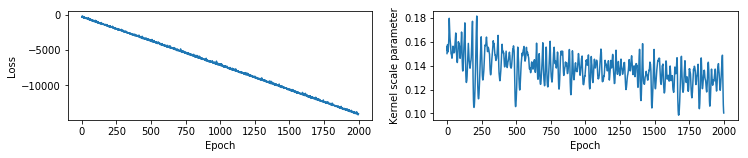

In [25]:
# prot loss function and kernel length
fig, (loss, kern) = plt.subplots(1,2,figsize=(12,2))
loss.plot(losses)
loss.set_xlabel("Epoch")
loss.set_ylabel("Loss")
kern.plot(rbf)
kern.set_xlabel("Epoch")
kern.set_ylabel("Kernel scale parameter")
fig.show()

In [26]:
test_x = torch.linspace(0, 5, 500)

In [27]:
data_gp.eval()

model.eval()

with torch.no_grad():
    output_dist = model(omega)
    
samples = output_dist.sample(torch.Size((20,)))

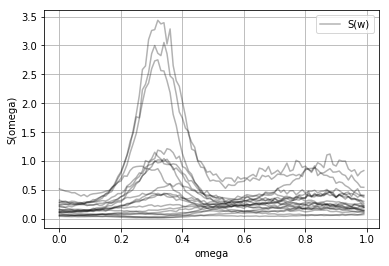

In [28]:
for i, sample in enumerate(samples):
    if i is 0:
        plt.plot(omega, sample.exp(), color = 'black', alpha = 0.3, label = 'S(w)')
    else:
        plt.plot(omega, sample.exp(), color = 'black', alpha = 0.3)

plt.xlabel('omega')
plt.ylabel('S(omega)')
plt.grid()
plt.legend()

torch.Size([100]) (100,)
torch.Size([100]) (100,)
torch.Size([100]) (100,)
torch.Size([100]) (100,)
torch.Size([100]) (100,)
torch.Size([100]) (100,)
torch.Size([100]) (100,)
torch.Size([100]) (100,)
torch.Size([100]) (100,)
torch.Size([100]) (100,)
torch.Size([100]) (100,)
torch.Size([100]) (100,)
torch.Size([100]) (100,)
torch.Size([100]) (100,)
torch.Size([100]) (100,)
torch.Size([100]) (100,)
torch.Size([100]) (100,)
torch.Size([100]) (100,)
torch.Size([100]) (100,)
torch.Size([100]) (100,)


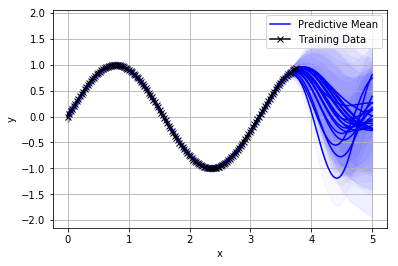

In [29]:
for i, sample in enumerate(samples):
    with gpytorch.settings.fast_pred_var():
        pred_dist = data_gp(sample, test_x)
    
    pred_mean = pred_dist.mean.data.numpy()
    lower, upper = pred_dist.confidence_region()
    
    if i is 0:
        plt.plot(test_x, pred_mean, color = 'blue', label = 'Predictive Mean')
    else:
        plt.plot(test_x, pred_mean, color = 'blue')
    
    plt.fill_between(test_x.numpy(), lower.data.numpy(), upper.data.numpy(), alpha = 0.03, color = 'blue')
    
plt.plot(train_x, train_y, marker = 'x', color = 'black', label = 'Training Data')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.legend()